<div style="display:flex; border-bottom:4px solid gray; background-color: white; padding: 10px;">
    <div>
        <h2 style="margin:10px 0px 0px 0px;">Scientific Article - July 2023</h2>
        <h4 style="margin:10px 10px 10px 0px;"><i>Artificial Intelligence - Data Science</i></h4>
    </div>
    <img src="img/UrFU-RTF_noinstitute.jpg" style="width:350px; height:150px; margin-right: 25px;" align='right' />
</div>
<h4 style="margin-top:10px; text-align:right; font-size: 20px; margin-right: 25px;"> Jarno Matarmaa - 06.2023 - Version-1.0-local</h4>

# Multivariate Time Series Classification in Sport Data

This project code downloads data from https://www.data.world/jamasoftwares

---

**TASKS**
- **[TODO (later)]** Modify TCX to CSV converter program to insert date of activity to metadata. That will be useful, for example, when checking misclassification issues.

**CHANGE LOG**
- [02.07.2023] Hyperparameter optimization process finished. No improvement with certain parameter combination observed, previously used was the best one. With certain window_inc/alphapet_size it was possible to slightly increase accuracy when using different signal lengths.
- [02.07.2023] Signal length analysis with graphs inserted.
- [26.06.2023] There seems to be some *probably problematic* speed data (check strip plot in "seaborn extra"). Check possibility to filter that data out.
  * Actually all the categories contain zero speed data. Those zero speed segments could be considered when selecting appropriate segments from the original sport activities. Here the data amount is too little to filter those segements out
- [23.06.2023] Signal length integrated to data download before signal visualizations
- [22.06.2023] Violin and strip plots inserted using seaborn builtin functionalities
- [16.06.2023] Data categories expanded to 5, manually checked 297 activities and "Other" label corrected to a specific activity.
- [15.06.2023] Project initialization

**QUESTIONS**

---

## 1 - Libraries

Python Dependencies

- `sktime`
- `sklearn`
- `pyts`

The list is not completed

#### General

In [1]:
# System tools
import sys
import os
# Data manipulation tools
import pandas as pd
import numpy as np
# Datetime
from tqdm import tqdm
from time import time
from datetime import datetime
# Data visualization tools
import matplotlib.pyplot as plt
import ipywidgets as widgets
%matplotlib inline
# Seaborn setup
import seaborn as sns
# Extra tools
from matplotlib import gridspec

#### Classifiers, data processing, and analysis metrics

In [2]:
# Classifiers
from sktime.classification.dictionary_based import MUSE # WEASEL+MUSE (multivariate version of WEASEL)
from sktime.classification.early_classification._teaser import TEASER # This is for different signal lengths
# Data processing
from sklearn.model_selection import train_test_split
from sktime.datatypes._panel._convert import from_2d_array_to_nested, from_nested_to_3d_numpy
# Metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error, RocCurveDisplay
# More analysis tools
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
# Pyts library
from pyts.multivariate.transformation import WEASELMUSE

#### Advanced signal analysis

In [3]:
# Signal transformers
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.transformations.panel.summarize._extract import DerivativeSlopeTransformer
from sktime.transformations.panel.dwt import DWTTransformer
from sktime.transformations.panel.slope import SlopeTransformer
from sktime.transformations.panel.dictionary_based import SFAFast, SFA, SAX
from sktime.transformations.series.acf import AutoCorrelationTransformer

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#### Visualization style setup 

- Modify file `./styles/plotstyles.mplstyle` in order to change styles

In [4]:
def reset_style():
    plt.style.use('default') # Reset style using the following script
    plt.style.use('./styles/plotstyles.mplstyle')

In [5]:
reset_style()
cmap = sns.color_palette("muted", 10)
THEMA_COLOR = cmap[9]
FIG_WIDTH = 14
cmap

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

Set style for seaborn 

- Note: Seaborn uses matplotlib styles, as it simply integrates matplotlib, there is no need to set styles separately

In [6]:
#sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

#### File path setup

In [7]:
PATH_RES = 'results/'

## 2 - Data download

#### Preparations and import

1. Install appropriate python library to download data from data.world

https://pypi.org/project/datadotworld/

In [8]:
import datadotworld as dw

2. Find your API token from the address:
- https://data.world/settings/advanced

3. Set up API token in command prompt
- `dw configure`



In [9]:
# This will download data to a local directory (sport_data/)
#dw.api_client(profile='jarnoma').download_datapackage('jamasoftwares/outdoor-sport-activities-mts','sport_data/')

In [10]:
DATA = dw.load_dataset('jamasoftwares/outdoor-sport-activities-mts-5', force_update=True, profile='jarnoma')

In [11]:
DATA.dataframes

LazyLoadedDict({'alt_data_std_1160x69': LazyLoadedValue(<pandas.DataFrame>), 'hr_data_std_1160x69': LazyLoadedValue(<pandas.DataFrame>), 'meta_data_1160x1': LazyLoadedValue(<pandas.DataFrame>), 'spd_data_std_1160x69': LazyLoadedValue(<pandas.DataFrame>)})

#### Signal length selector

In [12]:
@widgets.interact(SignalLen=widgets.IntSlider(60, 10, 60, 1, layout=widgets.Layout(width='500px')))
def set_signal_length(SignalLen):
    global HR_DATA, SPD_DATA, ALT_DATA, META, SLEN
    SLEN = SignalLen
    HR_DATA = DATA.dataframes['hr_data_std_1160x69'].iloc[:,:SLEN]
    SPD_DATA = DATA.dataframes['spd_data_std_1160x69'].iloc[:,:SLEN]
    ALT_DATA = DATA.dataframes['alt_data_std_1160x69'].iloc[:,:SLEN] # You may try differentials adding this .diff(2, axis=1).fillna(0)
    META = DATA.dataframes['meta_data_1160x1']
    print(f'SIGNAL LENGTH SET TO %d' % SLEN)

interactive(children=(IntSlider(value=60, description='SignalLen', layout=Layout(width='500px'), max=60, min=1…

## 3 - Data sample visualizations

In [13]:
reset_style()

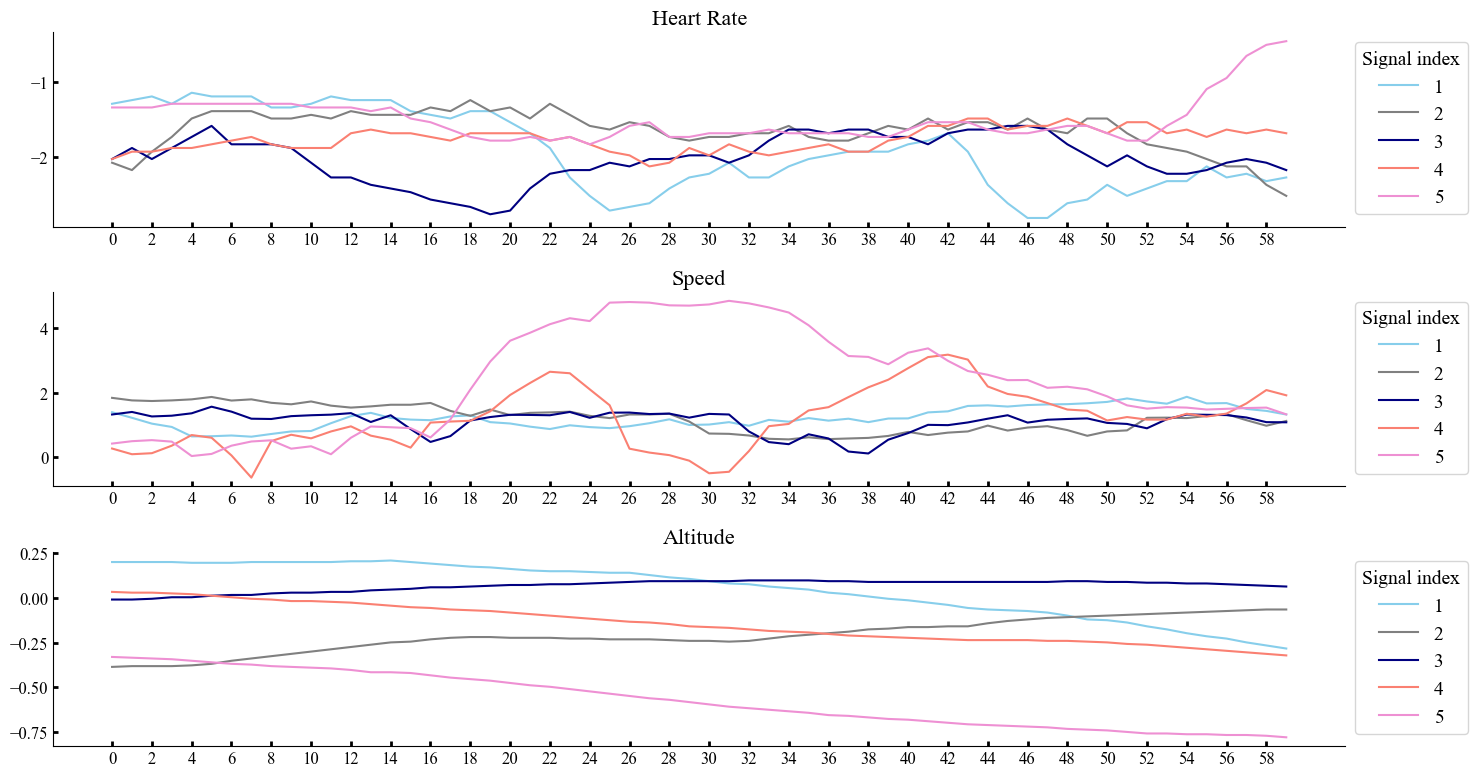

In [14]:
fig, ax = plt.subplots(3,figsize=(15,8))

def plot_sample(ax, data, title, legend=['1','2','3','4','5'], loc='upper left', color=None):
    ax.set_title(title)
    ax.plot(data, color=color)
    ax.legend(legend, loc=loc, title='Signal index', bbox_to_anchor=(1,1))
    ax.set_xticks(ax.get_xticks()[::2])

# Scaled data plots
plot_sample(ax[0], HR_DATA[0:5].T, 'Heart Rate')
plot_sample(ax[1], SPD_DATA[0:5].T, 'Speed')
plot_sample(ax[2], ALT_DATA[0:5].T, 'Altitude')

plt.tight_layout()
plt.show()

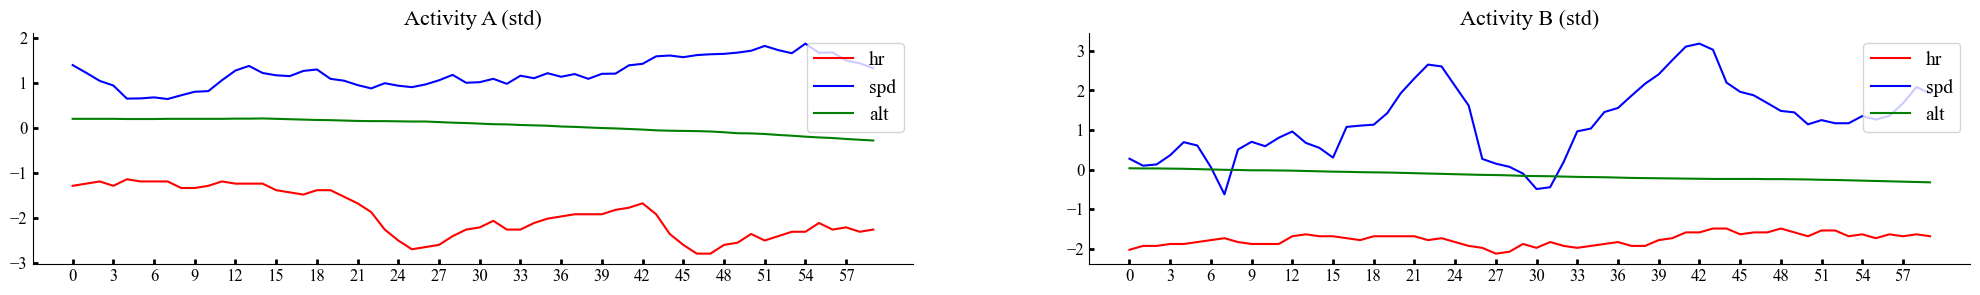

In [15]:
fig, ax = plt.subplots(1,2,figsize=(25,3))

ax[0].set_title('Activity A (std)')
ax[0].plot(HR_DATA.iloc[0,:].T, color='red')
ax[0].plot(SPD_DATA.iloc[0,:].T, color='blue')
ax[0].plot(ALT_DATA.iloc[0,:].T, color='green')
ax[0].legend(['hr','spd','alt'], loc='upper right')
ax[0].set_xticks(np.arange(0,SLEN,3))

ax[1].set_title('Activity B (std)')
ax[1].plot(HR_DATA.iloc[3,:].T, color='red')
ax[1].plot(SPD_DATA.iloc[3,:].T, color='blue')
ax[1].plot(ALT_DATA.iloc[3,:].T, color='green')
ax[1].legend(['hr','spd','alt'], loc='upper right')
ax[1].set_xticks(np.arange(0,SLEN,3))

plt.show()

## 4 - Dataset construction

Generating nested data structure

In [16]:
df_nest_hr = from_2d_array_to_nested(np.array(HR_DATA))
df_nest_spd = from_2d_array_to_nested(np.array(SPD_DATA))
df_nest_alt = from_2d_array_to_nested(np.array(ALT_DATA))

df_nest_hr

,0
0,0 -1.292042 1 -1.243334 2 -1.194626 3...
1,0 -2.071370 1 -2.168786 2 -1.925246 3...
2,0 -2.022662 1 -1.876538 2 -2.022662 3...
3,0 -2.022662 1 -1.925246 2 -1.925246 3...
4,0 -1.340750 1 -1.340750 2 -1.340750 3...
...,...
1135,0 -2.607158 1 -2.607158 2 -2.558450 3...
1136,0 -2.168786 1 -2.022662 2 -1.973954 3...
1137,0 -0.269174 1 -0.269174 2 -0.220466 3...
1138,0 0.364030 1 0.315322 2 0.364030 3...


In [17]:
META

,org_index,label,device,devid
0,0,Biking,vivosport,2623
1,0,Biking,vivosport,2623
2,0,Biking,vivosport,2623
3,0,Biking,vivosport,2623
4,0,Biking,vivosport,2623
...,...,...,...,...
1135,279,Running,Garmin Forerunner 920XT,1765
1136,279,Running,Garmin Forerunner 920XT,1765
1137,279,Running,Garmin Forerunner 920XT,1765
1138,279,Running,Garmin Forerunner 920XT,1765


Multivariate nested data

In [18]:
df_multi = pd.DataFrame()
df_multi['hr'] = df_nest_hr
df_multi['spd'] = df_nest_spd
df_multi['alt'] = df_nest_alt
df_multi['target'] = META.label.astype('category')
df_multi

,hr,spd,alt,target
0,0 -1.292042 1 -1.243334 2 -1.194626 3...,0 1.395859 1 1.223963 2 1.043623 3...,0 0.199348 1 0.199348 2 0.199348 3...,Biking
1,0 -2.071370 1 -2.168786 2 -1.925246 3...,0 1.840500 1 1.762005 2 1.743126 3...,0 -0.385848 1 -0.381576 2 -0.381576 3...,Biking
2,0 -2.022662 1 -1.876538 2 -2.022662 3...,0 1.326306 1 1.404801 2 1.265695 3...,0 -0.009955 1 -0.009955 2 -0.005684 3...,Biking
3,0 -2.022662 1 -1.925246 2 -1.925246 3...,0 0.274070 1 0.097704 2 0.129996 3...,0 0.032760 1 0.028488 2 0.028488 3...,Biking
4,0 -1.340750 1 -1.340750 2 -1.340750 3...,0 0.427086 1 0.501110 2 0.533403 3...,0 -0.330318 1 -0.334589 2 -0.338861 3...,Biking
...,...,...,...,...
1135,0 -2.607158 1 -2.607158 2 -2.558450 3...,0 -1.330118 1 -1.325150 2 -1.325150 3...,0 3.360260 1 3.360260 2 3.364532 3...,Running
1136,0 -2.168786 1 -2.022662 2 -1.973954 3...,0 -1.107549 1 -1.112020 2 -1.116988 3...,0 3.390161 1 3.385890 2 3.385890 3...,Running
1137,0 -0.269174 1 -0.269174 2 -0.220466 3...,0 -0.606768 1 -0.606768 2 -0.606768 3...,0 3.351717 1 3.355989 2 3.351717 3...,Running
1138,0 0.364030 1 0.315322 2 0.364030 3...,0 -0.430898 1 -0.435370 2 -0.444809 3...,0 3.355989 1 3.355989 2 3.360260 3...,Running


## 5 - Features and Sport categories

#### Label encoding

In [19]:
SPORT_CODES = {0: ('Biking','bik'), 1:('R-Skiing','rsk'), 2:('Running','run'), 3:('Skiing','ski'), 4:('Walking','wal')}
FEAT_CODES = {0:('Heart Rate','hr'), 1:('Speed','spd'), 2:('Altitude','alt')}

#### Functions for category and feature names

In [20]:
'''
Returns the list of all category names (abbreviations or full names) 
'''
def get_categories(abbr=False):
    if abbr:
        return [label[1] for label in list(SPORT_CODES.values())]
    else:
        return [label[0] for label in list(SPORT_CODES.values())]
    
'''
Returns the list of all category names (abbreviations or full names) 
'''
def get_cat_code(label, abbr=True):
    if abbr:
        for key, value in SPORT_CODES.items():
            if value[1]==label:
                return key
    else:
        for key, value in SPORT_CODES.items():
            if value[0]==label:
                return key
            
'''
Returns the full name of category abbreviation or vice versa 
'''
def get_cat(name, abbr=True):
    if abbr:
        index = [label[1] for label in list(SPORT_CODES.values())].index(name)
        return SPORT_CODES.get(index)[0]
    else:
        index = [label[0] for label in list(SPORT_CODES.values())].index(name)
        return SPORT_CODES.get(index)[1]

'''
Returns the list of all feature names (appreviations or full names)
'''  
def get_features(abbr=False):
    if abbr:
        return [label[1] for label in list(FEAT_CODES.values())]
    else:
        return [label[0] for label in list(FEAT_CODES.values())]
    
'''
Returns the list of corresponding codes for feature names 
'''
def get_feat_codes(names, abbr=True):
    codes = []
    for name in names:
        if abbr:
            index = [label[1] for label in list(FEAT_CODES.values())].index(name)
        else:
            index = [label[0] for label in list(FEAT_CODES.values())].index(name)
        codes.append(index)
                
    return codes

'''
Returns the list of corresponding feature names for codes (abbreviations or full names) 
'''
def get_feat_names(codes, abbr=True):
    feat_names = []
    if abbr:
        for code in codes:
            feat_names.append(FEAT_CODES.get(code)[0])
    else:
        for code in codes:
            feat_names.append(FEAT_CODES.get(code)[1])
        
    return feat_names
    

Use these functions to select items from the dictionaries

In [21]:
print(get_categories(abbr=False))
print(get_categories(abbr=True))
print(get_cat_code('rsk', abbr=True))
print(get_cat_code('R-Skiing', abbr=False))
print(get_cat('rsk',abbr=True))
print(get_cat('R-Skiing', abbr=False))

['Biking', 'R-Skiing', 'Running', 'Skiing', 'Walking']
['bik', 'rsk', 'run', 'ski', 'wal']
1
1
R-Skiing
rsk


In [22]:
print(get_feat_names([0,1,2]))
print(get_feat_names([0,1,2],abbr=False))
print(get_feat_codes(['hr','spd','alt']))
print(get_feat_codes(['Heart Rate','Speed','Altitude'],abbr=False))

['Heart Rate', 'Speed', 'Altitude']
['hr', 'spd', 'alt']
[0, 1, 2]
[0, 1, 2]


#### Category distribution

Text(0, 0.5, 'category')

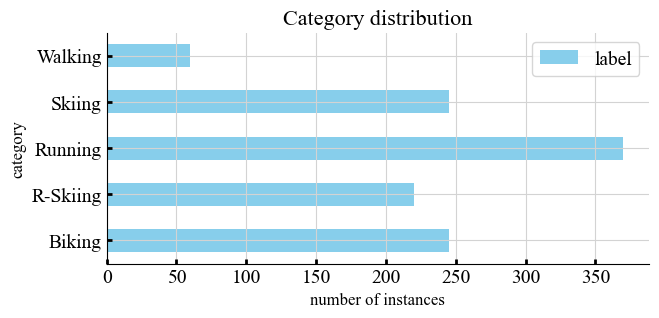

In [23]:
cat_distribution = META.groupby(['label'])['label'].count()
cat_distribution.plot(kind='barh', stacked=False, 
                      title='Category distribution',
                      xlabel='Category', ylabel='Instances', 
                      figsize=(7,3),
                      fontsize=14, rot=0, 
                      #color=['gray', 'lightgray'],
                      grid=True).legend(loc='upper right')
plt.xlabel('number of instances', fontsize=12)
plt.ylabel('category', fontsize=12)

---

## 6 - Multivariate Time Series Classification

### Functions

In [24]:
def plot_confmatrix(ax, yval, ypred):
    cm = pd.DataFrame(confusion_matrix(yval, ypred))
    cm_norm = cm.apply(lambda x: x/x.sum(), axis = 1)
    sns.set(font_scale=1.1) # for label size
    sns.heatmap(cm_norm, annot=True, xticklabels=('Biking', 'R-Skiing','Running','Skiing','Walking'), 
                                     yticklabels=('Biking', 'R-Skiing','Running','Skiing','Walking'),
                                     fmt='.1%',
                                     cmap='Blues',
                                     ax=ax,
                                     annot_kws={"size": 16}) # font size

In [25]:
# Classification report properties for matplotlip.table
col_colors = ['lightgray','lightgray','lightgray','lightgray','lightgray','skyblue','skyblue','skyblue']
row_colors = ['lightgray','lightgray','lightgray','lightgray']
cell_colors = [['white','white','white','white','white','lightgray','white','white'],
               ['white','white','white','white','white','lightgray','white','white'],
               ['white','white','white','white','white','lightgray','white','white'],
               ['white','white','white','white','white','lightgray','white','white']]

In [26]:
'''
Creates list of column names according to the parameters
- @general: Start of the column name
- @num: Identification number for column
Output for function call create_col_names(general='Score', num=3) 
=> ['Score 1','Score 2', 'Score 3']
'''
def create_col_names(general, num, info=False):
    col_names = []
    for i in range(1,num+1):
        col_names.append(general + str(i))
    
    if info: print("Columns created: ", col_names)
    
    return col_names

In [27]:
'''
Classification function which creates result tables. However, it does not create or print out any kind of analysis, 
such as correlation matrixes etc.
Data given as parameters have to be according to the classifier's requirements. 
Usability for different type of classifiers is quite flexible. 
Remember to use correct classifier type name from the list
clf_type = sktime | sklearn | sklearn-tree
'''
def classify(classifiers, clf_type, sig_len, X_train, X_test, y_train, y_test, results, preds, iters):
    # Pandas dataframe for results
    if results is None:
        results = pd.DataFrame(columns=['Classifier','Type','Signal(s)','Train(t)','Test(t)'])
        preds = pd.DataFrame()
    
    # Create column names for scores according to the number of iterations
    score_col_names = create_col_names('Score_', iters)
    
    # Create progress bar with non-default styles
    progress_bar = tqdm(classifiers.items(), ncols=100, colour='#87ceeb', file=sys.stdout)
    
    for name, clf in progress_bar:
        progress_bar.set_description("Processing \033[1m ➥%s \033[0m" % str(clf)) # Includes bold text printing
        score_row = pd.DataFrame(data={'Classifier': name,'Type': clf_type,'Signal(s)':sig_len}, index=[sig_len])
        
        # Insert score colums for each iterations
        for i in range(1,iters+1):
            score_row[score_col_names] = 0
        
        best_score = 0

        for iter in range(1,iters+1):
            start = time() # Start timing the model
            clf.fit(X_train, y_train)
            train_time = time() - start # Stop train timer
            start = time()              # Start test timer
            # Predictions
            y_pred = pd.Series(clf.predict(X_test)).astype('category')
            # Model scores
            score = accuracy_score(y_test, y_pred)
            score_time = time()-start
            # Set values (note: time data will be overwritten in each iteration)
            score_row['Train(t)'] = train_time
            score_row['Test(t)'] = score_time
            score_row[score_col_names[iter-1]] = score
            # Among iterations, we could take only one mse, f1 and roc. We store them for the best accuracy.
            if score > best_score:
                # STORE PREDICTIONS to a data frame
                preds[name] = y_pred
                # More metrics: MSE, F1 and ROC-AUC scores
                score_row['mse'] = mean_squared_error(y_test.cat.codes, y_pred.cat.codes)
                score_row['f1'] = f1_score(y_test, y_pred, average='micro')
                if clf_type not in ['sklearn']:
                    y_pred_proba = clf.predict_proba(X_test)
                    score_row['roc-auc'] = roc_auc_score(y_test, y_pred_proba, average="weighted", multi_class="ovr")
                else:
                    score_row['roc-auc'] = np.nan
                best_score = score
            
        results = pd.concat((results, score_row), axis=0, ignore_index=False)
        
    print('Classification done for ' + clf_type + '\n')
    
    return results, preds

In [28]:
'''
This classification funtion takes models and data as a function parameters ans prints out the results.
Notice, that results are only printed immediately when classification is completed, but nothing is stored. 
Therefore, when execution fails all the data will be lost. Be careful!
'''
def classify_report(models, x_train, y_train, x_test, y_test):
    for name, sktime_clf in models.items():
        # Classify
        clf = sktime_clf 
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        print(name, accuracy_score(y_test, y_pred))
        # Create figure and grid for different subplots
        fig = plt.figure(figsize=(23,5))
        spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 2], wspace=0.3)
        # Plot confusion matrix
        ax1 = fig.add_subplot(spec[0])
        plot_confmatrix(ax1, y_test, y_pred)
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('Actual')
        # Plot classification report
        report = pd.DataFrame(classification_report(y_test, y_pred, digits=3, output_dict=True))
        ax2 = fig.add_subplot(spec[1])
        font_size=16
        bbox=[0, 0, 1, 1]
        ax2.axis('off')
        mpl_table = ax2.table(cellText=np.round(report.values,4), 
                            rowLabels=report.index, bbox=bbox, 
                            colLabels=report.columns,
                            colColours=col_colors,
                            rowColours=row_colors,
                            cellColours=cell_colors,
                            edges='closed')
        mpl_table.auto_set_font_size(False)
        mpl_table.set_fontsize(font_size)
        plt.show()

### Start timer

<div style="display: block; padding: 15px; background-color: skyblue; color: white; height: auto; border-radius: 5px; width: 95vw;">
    <h3 style="font-size: 26px;"><b>Execution Information</b></h3>
    <p>Classification time: Individual classification with confusion matrix and multi-classification with 3 iterations</p>
</div>

In [29]:
run_start = datetime.now()

### Data splits

In [30]:
x_tr, x_te, y_tr, y_te = train_test_split(df_multi.iloc[:,0:3],
                                          df_multi.iloc[:,3],
                                          test_size=0.2,
                                          random_state=24,
                                          stratify=df_multi.iloc[:,3],
                                          shuffle=True)

In [31]:
x_tr.shape, x_te.shape

((912, 3), (228, 3))

### MUSE model

In [32]:
muse = MUSE(window_inc=5,
            alphabet_size=8,
            support_probabilities=True,
            use_first_order_differences=False,
            variance=False,
            bigrams=False,
            anova=False,
            feature_selection='chi2',
            p_threshold=0.05,
            random_state=0,
            n_jobs=1)

### Single classification with confusion matrix

MUSE 0.9210526315789473


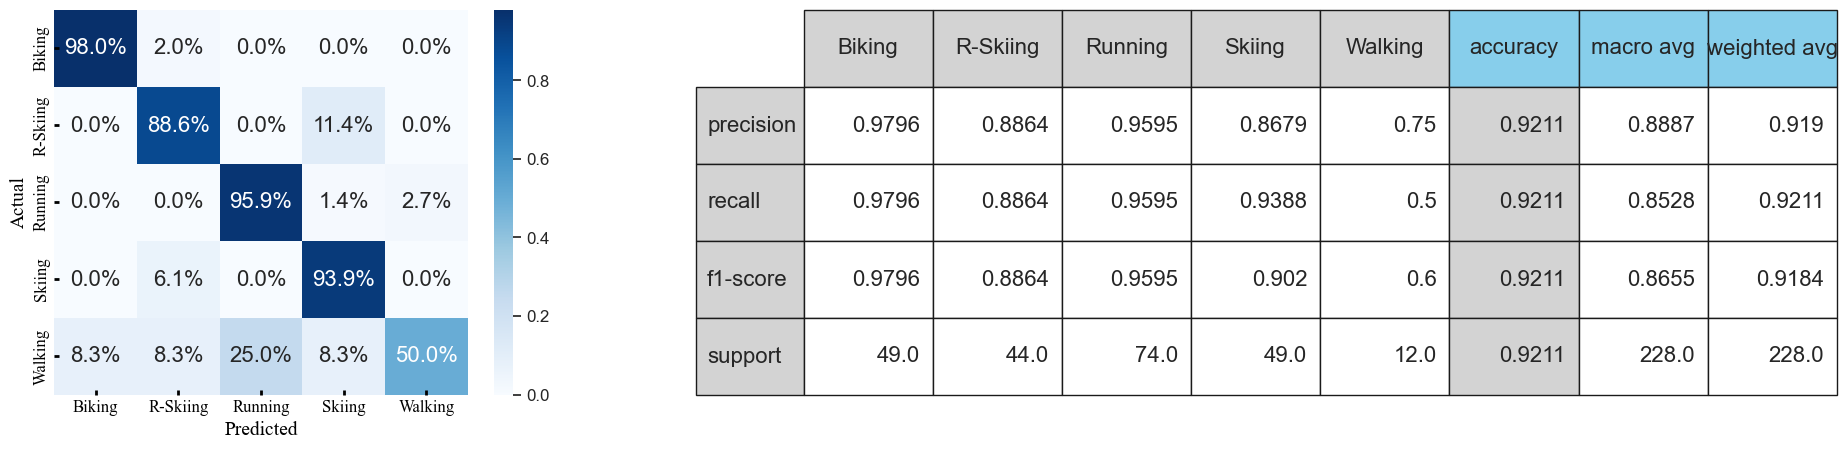

In [33]:
clfs = {'MUSE': muse}
classify_report(clfs, x_tr, y_tr, x_te, y_te)

**Conclusions**

As expected, there is confusion between Running-Walking and Skiing-RollerSkiing. However, as an exception there are one single RollerSkiing predicted as Biking (2.0%) and one single Skiing predicted as Running (1.4%).
Since we remember great result, 96,6% accuracy for MUSE from Master's Thesis project, wherein Skiing and Roller-Skiing were both in the "Other" category, this accuracy decreasement from 96,6% to 92,1% is understandable. It comes almost totally from confusions between those two very similar activities, and therefore it might be even impossible to discriminate them with 100% accuracy.
There were 12 Walking activities in the Test data from which 5 were miclassified by MUSE as a Running activity. That causes 41,7% mistake. As I also know, that some walking activities may contain some running segments and therefore be partly mislabeled even in the original dataset, also that results is quite understandable.

Considering these mentioned issues, 92,1% accuracy is still very good

### Iterative classification

In [34]:
results_muse, preds_muse = classify(clfs, 'sktime-multivar', SLEN, x_tr, x_te, y_tr, y_te, results=None, preds=None, iters=3)

Processing  ➥MUSE(alphabet_size=8, anova=False, bigrams=False, random_state=0,               | 0/1 [00:00<?, ?it/s]
     support_probabil

Processing  ➥MUSE(alphabet_size=8, anova=False, bigrams=False, random_state=0,
Processing  ➥MUSE(alphabet_size=8, anova=False, bigrams=False, random_state=0,
     support_probabil
Classification done for sktime-multivar



In [35]:
results_muse

,Classifier,Type,Signal(s),Train(t),Test(t),Score_1,Score_2,Score_3,mse,f1,roc-auc
60,MUSE,sktime-multivar,60,13.869579,1.304165,0.921053,0.921053,0.921053,0.350877,0.921053,0.98897


In [36]:
preds_muse['Valid'] = y_te.values
preds_muse

,MUSE,Valid
0,Biking,Biking
1,R-Skiing,R-Skiing
2,Running,Running
3,Biking,Biking
4,R-Skiing,R-Skiing
...,...,...
223,Biking,Biking
224,Skiing,Skiing
225,R-Skiing,R-Skiing
226,R-Skiing,R-Skiing


#### Stop timer

<div style="display: block; padding: 15px; background-color: gray; color: white; height: auto; border-radius: 5px; width: 95vw;">
    <h3 style="font-size: 26px;"><b>Execution Information</b></h3>
    <p>Classification time: Individual classification with confusion matrix and multi-classification with 3 iterations</p>
</div>

In [37]:
run_end = datetime.now()
run_time = run_end - run_start
print('File execution info:')
print('Start\t', run_start)
print('End\t', run_end)
print('Runtime\t', str(run_time))

File execution info:
Start	 2023-07-12 19:57:39.087036
End	 2023-07-12 19:58:48.525486
Runtime	 0:01:09.438450


### Save results

* Time stamp and signal length are used as an identifier for each classification case

In [38]:
time_stamp = datetime.now().strftime("D%Y%m%d_T%H%M")
results_slen_filename = 'results_by_slen.csv'
results_filename = f'results_SLEN=%d_CASE=%s' % (SLEN, time_stamp)
preds_filename = f'preds_SLEN=%d_CASE=%s' % (SLEN, time_stamp)

results_filename

'results_SLEN=60_CASE=D20230712_T1958'

In [39]:
 #results_filename = results_filename + '_alt-diff'

In [40]:
results_muse.to_csv(PATH_RES + results_filename + '.csv', index=False)
preds_muse.to_csv(PATH_RES + preds_filename + '.csv', index=False)

In [41]:
results_muse

,Classifier,Type,Signal(s),Train(t),Test(t),Score_1,Score_2,Score_3,mse,f1,roc-auc
60,MUSE,sktime-multivar,60,13.869579,1.304165,0.921053,0.921053,0.921053,0.350877,0.921053,0.98897


In [42]:
if os.path.exists(PATH_RES + results_slen_filename):
    results_from_file = pd.read_csv(PATH_RES + results_slen_filename, index_col=0)
    results_from_file.loc[SLEN] = results_muse.loc[SLEN]
    results_from_file.to_csv(PATH_RES + results_slen_filename)
else:
    results_muse.to_csv(PATH_RES + results_slen_filename)

results_from_file.sort_values(by='Signal(s)')

,Classifier,Type,Signal(s),Train(t),Test(t),Score_1,Score_2,Score_3,mse,f1,roc-auc
10,MUSE,sktime-multivar,10,0.917797,0.149663,0.570175,0.570175,0.570175,2.223684,0.570175,0.853522
15,MUSE,sktime-multivar,15,1.726821,0.201672,0.785088,0.785088,0.785088,1.171053,0.785088,0.951970
20,MUSE,sktime-multivar,20,2.478711,0.285949,0.855263,0.855263,0.855263,0.614035,0.855263,0.970580
25,MUSE,sktime-multivar,25,3.190064,0.343083,0.868421,0.868421,0.868421,0.640351,0.868421,0.975765
30,MUSE,sktime-multivar,30,4.279598,0.435606,0.885965,0.885965,0.885965,0.451754,0.885965,0.983037
35,MUSE,sktime-multivar,35,5.378523,0.471016,0.903509,0.903509,0.903509,0.464912,0.903509,0.985048
40,MUSE,sktime-multivar,40,6.479097,0.562547,0.903509,0.903509,0.903509,0.478070,0.903509,0.987756
45,MUSE,sktime-multivar,45,7.599826,0.718327,0.912281,0.912281,0.912281,0.478070,0.912281,0.988618
50,MUSE,sktime-multivar,50,10.525608,0.875066,0.929825,0.929825,0.929825,0.377193,0.929825,0.986660
55,MUSE,sktime-multivar,55,10.237348,0.866261,0.929825,0.929825,0.929825,0.328947,0.929825,0.986906


---

## 7 - Analysis

Functions

In [43]:
def concat(data: list, feat: int, cols: list, diff=False) -> pd.DataFrame:
    # Data frame for concatenated category values
    concat_data = pd.DataFrame(columns=cols)
    # Here we concatenate Heart Rate data to the same column for each category
    for cat in cols[:-1]: # Supposing there is a 'timepoint' column in last index in 'cols'
        cat_code = get_cat(cat, abbr=False)
        if diff:
            concat_data[cat] = pd.DataFrame(ColumnConcatenator().fit_transform(data[feat].get(cat_code).diff().T.values))
        else:
            concat_data[cat] = pd.DataFrame(ColumnConcatenator().fit_transform(data[feat].get(cat_code).T.values))
    # Signal time point column for concatenated category data in order to plot confidence intervals by seaborn
    concat_data.timepoint = np.tile(np.arange(0,SLEN), int(concat_data.shape[0]/SLEN))
    
    return concat_data

In [44]:
def construct_plot_data(cat_data, diff_feats: list=[]):
    cats = get_categories(abbr=False)
    cats.append('timepoint')
    
    data_collection = pd.DataFrame(columns=['timepoint','cats','vals_hr','vals_spd','vals_alt'])
    hr = concat(cat_data, 0, cats, 0 in diff_feats).melt('timepoint',var_name='cats', value_name='vals')
    spd_vals = concat(cat_data, 1, cats, 1 in diff_feats).melt('timepoint',var_name='cats', value_name='vals')['vals']
    alt_vals = concat(cat_data, 2, cats, 2 in diff_feats).melt('timepoint',var_name='cats', value_name='vals')['vals']
    data_collection.timepoint = hr.timepoint
    data_collection.cats = hr.cats
    data_collection.vals_hr = hr.vals
    data_collection.vals_spd = spd_vals
    data_collection.vals_alt = alt_vals
    
    return data_collection

In [45]:
def print_stats(regressor):
    # Signal statistics
    print(f"coefficient of determination: {regressor.score(x, y)}")
    print(f"intercept: {regressor.intercept_}")
    print(f"slope: {regressor.coef_}")

In [46]:
def plot_signal_sample(data, idxs, color, title):
    # This will give us short names of the features as defined in the global variable FEAT_CODES
    feats = [i[1] for i in FEAT_CODES.values()]
    fig, axs = plt.subplots(2,3, figsize=(18,6), edgecolor=color, linewidth=4, sharey=True)
    fig.suptitle(title, y=1.0)

    for i, ax in enumerate(axs.flat):
        ax.plot(data[feats[0]][idxs[i]], lw=1)
        ax.plot(data[feats[1]][idxs[i]], lw=1)
        ax.plot(data[feats[2]][idxs[i]], lw=1)
        ax.set_title("Index: %d | Correct %s / Predicted %s" % (idxs[i], preds_muse.Valid[idxs[i]], preds_muse.MUSE[idxs[i]]))
        ax.grid(visible=False)

    plt.setp(axs[-1,:], xlabel='Signal length (s)')
    plt.setp(axs[:,0], ylabel='Value (std)')
    plt.tight_layout()
    plt.show()

In [47]:
def plot_cat_signals(ax, data, oper, title):
    if oper == 'mean':
        ax.set_title(title + ' ' + oper + ' signals')
        for key, item in data.items():
            ax.plot(item.mean(), label=get_cat(key, abbr=True))
    elif oper == 'diff_mean':
        ax.set_title(title + ' ' + oper + ' signals')
        for key, item in data.items():
            ax.plot(item.abs().diff().mean(), label=get_cat(key, abbr=True))

    ax.set_xlabel('Time point(s)')
    ax.set_xticks(np.arange(0,SLEN,5))
    ax.grid(visible=False)

In [48]:
def plot_reg(ax, signal):
    x = np.arange(0,len(signal)).reshape(-1, 1)
    y = signal
    hrreg = LinearRegression().fit(x, y)
    y_pred = hrreg.predict(x)
    ax.plot(y_pred, label='Regression', color='black', linestyle='-.')
    

In [49]:
def plot_analysis(cat_data: list, feat: int, sig: tuple):
    SIG = sig[0]
    sig_idx = sig[1]
    sig_cat = sig[2]
    sig_lbl = 'SofA: ' + sig_cat
    # Data for fluent printing and setup (some of these are dependent of data variable column names)
    feats = get_features(abbr=True) # This will give us short names of the features as defined in the global variable FEAT_CODES
    fig, ax = plt.subplots(1,2,figsize=(FIG_WIDTH,3))
    fig.suptitle(FEAT_CODES.get(feat)[0] + ' signals for index ' + str(sig_idx) + ' (' + sig_cat + ') ' + '\nOriginal, Regression & Rolling Mean', y=1.2)
     
    # REGRESSION
    plot_reg(ax[0], SIG[feats[feat]])
    plot_cat_signals(ax[0], cat_data[feat], 'mean', FEAT_CODES.get(feat)[0])

    # REGRESSION, ROLLING MEAN and ORIGINAL
    ax[1].plot(SIG[feats[feat]], label=sig_lbl, color='black', linestyle='dotted')
    ax[1].plot(SIG[feats[feat]].rolling(window=6).mean(), label='Rolling mean', color='black', linestyle='--')
    plot_reg(ax[1], SIG[feats[feat]])
    plot_cat_signals(ax[1], cat_data[feat], 'mean', FEAT_CODES.get(feat)[0])
    
    ax[1].legend(loc='upper left', bbox_to_anchor=(1,1))
    
    plt.show()

In [50]:
def plot_mean_analysis(data: list, feat: int, sig: tuple):
    SIG = sig[0]     # This is expected to be pandas dataframe with hr, spd and alt columns (The whole signal data)
    sig_idx = sig[1] # This is only for printing
    sig_cat = sig[2]
    sig_lbl = 'SofA: ' + sig_cat
    # Data for fluent printing and setup (some of these are dependent of data variable column names)
    feats = get_features(abbr=True) # This will give us short names of the features as defined in the global variable FEAT_CODES
    columns = get_categories(abbr=False)
    columns.append('timepoint')
    # Concatenate
    concat_data = concat(data, feat, columns)
    # Plot mean signals with confidence intervals
    fig, ax = plt.subplots(1,2,figsize=(FIG_WIDTH,3))
    fig.suptitle('Category: ' + sig_cat + ', Feature: ' + FEAT_CODES.get(feat)[0] + ', Signal index ' + str(sig_idx), y=1.1)
    sns.regplot(x=SIG.index, y=SIG[feats[feat]], ci=95, ax=ax[0])
    # This plots the individual signal of analysis
    sns.lineplot(x=SIG.index, y=SIG[feats[feat]], label=sig_lbl, c='black',linestyle='dashed', ax=ax[1])
    # This plots mean signals with confidence intervals
    for cat in columns[:-1]:
        sns.lineplot(concat_data, x=concat_data.timepoint, y=cat, label=cat, errorbar=('ci', 95), n_boot=100, ax=ax[1])
    # Set sub titles
    ax[0].set_title('Regression plot of investigated signal, category: ' + sig_cat)
    ax[0].set_xlabel('timepoint')
    ax[0].set_ylabel(get_feat_names([feat])[0])
    ax[1].legend(loc='upper left', bbox_to_anchor=(1,1)) # columns[:-1].insert(0,sig_lbl)
    ax[1].set_title('Mean signals with confidence intervals by category')
    ax[1].set_ylabel(get_feat_names([feat])[0])
    
    plt.show()

In [51]:
def plot_cat_analysis(data: list, feats: tuple, plot_type: str):
    # This functions supposes these column names in the data frame
    col_dict = {'vals_hr':'Heart Rate','vals_spd':'Speed','vals_alt':'Altitude'}
    if len(feats) < 1:
        print('Please, select features!')
    else:
        # Strip plot
        g = None
        plot_data = construct_plot_data(data)
        cols = list(plot_data.columns[1:2].values)
        
        if plot_type in ['violin','strip']:
            cats = get_categories(abbr=False)
            cats.append('timepoint')
            for feat in feats:
                concat_data = concat(data, feat, cats)
                df_melt = concat_data.melt('timepoint',var_name='cats', value_name='vals')
                g = sns.catplot(kind=plot_type, data=df_melt, x='cats', y='vals',  height=4, aspect=8/4, size=2)
                g.set(title=FEAT_CODES.get(feat)[0] + ' value distribution by category',
                      xlabel='Category', ylabel='Value(std)')
        
        elif plot_type=='pair':
            # Pair plot
            cols.extend([['vals_hr','vals_spd','vals_alt'][i] for i in feats])
            g = sns.pairplot(data=plot_data[cols], hue='cats')
            g.fig.suptitle('Paiplots of features')
            g.set(xlabel=col_dict.get(cols[1]), ylabel=col_dict.get(cols[2]))
        
        elif plot_type=='lm':
            # Regression-scatter plot
            if len(feats) < 2:
                cols.extend(['vals_hr','vals_spd'])
            else:
                cols.extend([['vals_hr','vals_spd','vals_alt'][i] for i in feats])
            g = sns.lmplot(data=plot_data[cols], x=cols[1], y=cols[2], hue="cats", legend=False, x_bins=500,
                        markers='o', height=6, aspect=1.2, scatter_kws={'s':15,'edgecolors':'lightgray','linewidth':1})
            g.fig.suptitle(f'Scatter/Regression plot of features')
            g.set(xlabel=col_dict.get(cols[1]), ylabel=col_dict.get(cols[2]))
            g.fig.legend(title='Category', bbox_to_anchor=(1,0.5), loc='center left')
            
        g.fig.subplots_adjust(top=0.90) # Reduce plot to make room 
        plt.show()

In [52]:
def plot_cat_analysis_single(cat_data, feats: tuple=(0,1), cats: list=None, plot_type: str='kde', lims=None, cmap=None, fc=None, h=7):
    reset_style()
    data = construct_plot_data(cat_data)
    plot_type_dict = {'kde':'KDE','reg':'Regression','hex':'Hexagonal','scatter':'Scatter'}
    feat_cols_dict = {'vals_hr':'Heart Rate','vals_spd':'Speed','vals_alt':'Altitude'}
    feat_cols = list(feat_cols_dict.keys()) # Do not confuse the order of these items
    image_h = h
    alpha = 0.9
    
    # Some variable setups
    if type(lims)==list: # In this case user wants to define axis limits
        # Expected list with two tuples indicating value range [x=(start,end), y=(start,end)]
        x_lims=lims[0]
        y_lims=lims[1]
    else:
        x_lims=None
        y_lims=None
    
    if cats==None:
        cats = get_categories()

    plot_data = data[data.cats.isin(cats)]
    cat_name = str(cats)
        
    if plot_type=='kde':
        g = sns.FacetGrid(plot_data, col="cats", height=image_h, aspect=0.8, col_wrap=FIG_WIDTH)
        g.map(sns.kdeplot, feat_cols[0], feat_cols[1],
            fill=True, thresh=0, levels=100, cmap=cmap, alpha=alpha)
        for i in np.arange(0,len(cats)):
            g.axes[i].collections[0].set_facecolor(fc)
        g.set_axis_labels(x_var='heart rate', y_var='speed')
        g.set_titles(col_template='{col_name}')
        
    elif plot_type=='kde-aio':
        g = sns.jointplot(kind='kde', data=plot_data, x=feat_cols[0], y=feat_cols[1], height=image_h, cmap=cmap,
                          fill=True, thresh=0, levels=100, alpha=alpha)
        
    elif plot_type=='hex':
        g = sns.jointplot(kind='hex', data=plot_data, x=feat_cols[0], y=feat_cols[1], height=image_h, cmap=cmap)
    
    elif plot_type=='scatter':
        g = sns.jointplot(kind='scatter', data=plot_data, x=feat_cols[0], y=feat_cols[1], height=image_h,
                            hue='cats', marker="o", s=20, edgecolors='white', linewidth=1, cmap=cmap, alpha=alpha)
        #g.fig.legend(title='Category', bbox_to_anchor=(1,0.5), loc='center left')
    
    elif plot_type=='reg':
        g = sns.jointplot(kind="reg", data=plot_data, x=feat_cols[0], y=feat_cols[1], height=image_h,
                            x_ci='timepoint', scatter_kws={"s":20,'edgecolors':'white','linewidth':1})
    
    if fc==None:
        if plot_type not in ['reg','hex','kde']:
            fc1 = g.ax_marg_x.collections[0].get_facecolor()
            g.ax_marg_x.collections[0].set_facecolor(fc1)
            fc2 = g.ax_joint.collections[0].get_facecolor()
            g.ax_joint.collections[0].set_facecolor(fc2)
        
    elif plot_type not in ['kde']:
        g.ax_marg_x.collections[0].set_facecolor(fc)
        g.ax_marg_y.collections[0].set_facecolor(fc)
        g.ax_joint.collections[0].set_facecolor(fc)
        g.ax_joint.collections[0].set_alpha(alpha)
        
        g.fig.suptitle(f'%s HR-Speed: %s' % (plot_type_dict.get(plot_type), cat_name))
        g.set_axis_labels(xlabel=feat_cols_dict.get(feat_cols[0]), ylabel=feat_cols_dict.get(feat_cols[1]))
            
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.90) # Reduce plot to make room 
    plt.show()
    

In [53]:
def get_signal3D(data, labels, idx):
    signal3D = data.iloc[idx,:]
    label = labels.iloc[idx]
    df_sig = pd.DataFrame()
    df_sig['hr'] = signal3D.hr
    df_sig['spd'] = signal3D.spd
    df_sig['alt'] = signal3D.alt
    return df_sig, label

### 7.1 ROC-AUC

In [54]:
muse = clfs.get('MUSE')

In [55]:
muse.fit(x_tr, y_tr)

MUSE(alphabet_size=8, anova=False, bigrams=False, random_state=0,
     support_probabilities=True, use_first_order_differences=False,
     window_inc=5)

In [56]:
y_pred = muse.predict(x_te)
print('model', accuracy_score(y_te, y_pred))
print(classification_report(y_te, y_pred, digits=3))

model 0.9210526315789473
              precision    recall  f1-score   support

      Biking      0.980     0.980     0.980        49
    R-Skiing      0.886     0.886     0.886        44
     Running      0.959     0.959     0.959        74
      Skiing      0.868     0.939     0.902        49
     Walking      0.750     0.500     0.600        12

    accuracy                          0.921       228
   macro avg      0.889     0.853     0.865       228
weighted avg      0.919     0.921     0.918       228



In [57]:
#sktime_clfs.get('TSF').predict(x_test)
y_score = muse.predict_proba(x_te)

In this section we use a LabelBinarizer to binarize the target by one-hot-encoding in a OvR fashion. This means that the target of shape (n_samples,) is mapped to a target of shape (n_samples, n_classes).

In [58]:
label_binarizer = LabelBinarizer().fit(y_tr.cat.codes)
y_onehot_test = label_binarizer.transform(y_te.cat.codes)
y_onehot_test.shape  # (n_samples, n_classes)

(228, 5)

We can as well easily check the encoding of a specific class:

In [59]:
label_binarizer.transform([1])

array([[0, 1, 0, 0, 0]])

In [60]:
reset_style()

0.9889697350336057


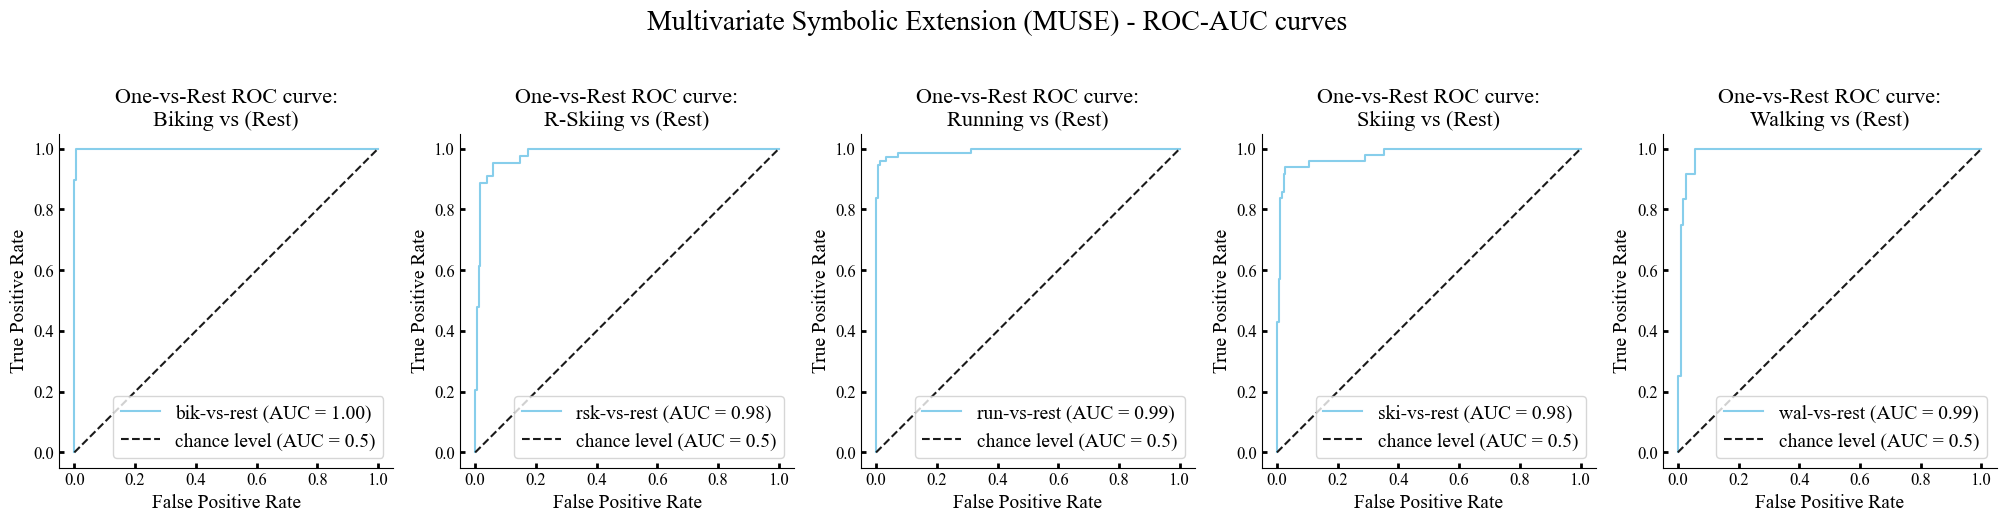

In [61]:
# Print roc-auc using sklearn function
print(roc_auc_score(y_te, y_score, average="weighted", multi_class="ovr"))

fig, ax = plt.subplots(1,5,figsize=(25,6))

for f in [0,1,2,3,4]:

    class_of_interest = f
    class_abbr = SPORT_CODES.get(f)[1]
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{class_abbr}-vs-rest",
        #color="darkorange",
        ax=ax[f]
    )
    ax[f].plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    ax[f].axis("square")
    ax[f].set_xlabel("False Positive Rate")
    ax[f].set_ylabel("True Positive Rate")
    ax[f].set_title(f'One-vs-Rest ROC curve:\n%s vs (Rest)' % SPORT_CODES.get(f)[0])
    ax[f].legend()

fig.suptitle('Multivariate Symbolic Extension (MUSE) - ROC-AUC curves', fontsize=20)
plt.show()

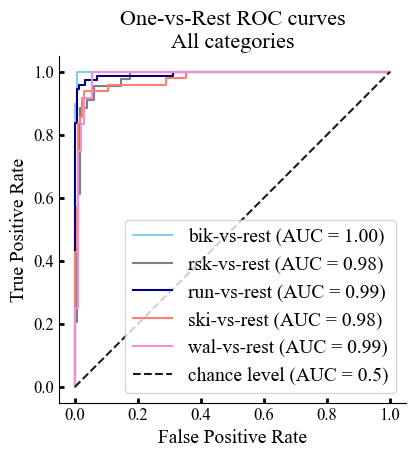

In [62]:
fig, ax = plt.subplots(1,1,figsize=(4.5,4.5))

for f in [0,1,2,3,4]:

    class_of_interest = f
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{[label[1] for label in list(SPORT_CODES.values())][class_of_interest]}-vs-rest",
        ax=ax
    )
    
ax.axis("square")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title('One-vs-Rest ROC curves\nAll categories')
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
ax.legend()#loc='upper left', bbox_to_anchor=(1,0.7))

plt.show()

RocCurveDisplay confuses matplotlib styles. Here we try to recover styles

### 7.2 Signal length analysis

In [63]:
reset_style()

Functions

In [64]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val*100}, axis=1)
    for i, point in a.iterrows():
        t = ax.text(point['x']-1, point['y']+0.05, f'%.2f%%' % point['val'], fontsize=10)
        if point['x'] > 40:
            t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

Get data and optimize dataframe for seaborn visualization

In [65]:
clf_data = results_from_file.sort_values(by='Signal(s)')[['Signal(s)','Score_1','Train(t)','Test(t)']]
# Renaming columns
clf_data = clf_data.rename(columns={'Score_1':'Accuracy'})
# Value normalization to present data in the same plot
norm_tr = clf_data['Train(t)']
norm_te = clf_data['Test(t)']
clf_data['Train(t)'] = (norm_tr-norm_tr.min())/(norm_tr.max()-norm_tr.min())
clf_data['Test(t)'] = (norm_te-norm_te.min())/(norm_te.max()-norm_te.min())
# Restructuring data for seaborn compatible format
clf_data_melt = pd.melt(clf_data, id_vars=['Signal(s)'], value_vars=['Accuracy','Train(t)','Test(t)'])

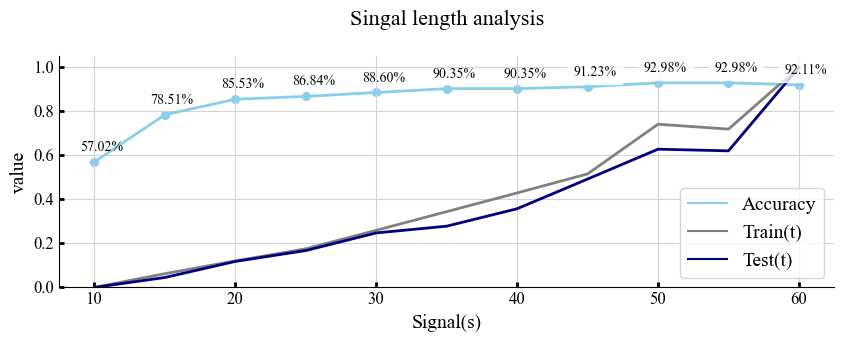

In [83]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
sns.lineplot(data=clf_data_melt, x='Signal(s)', y='value', hue='variable', linewidth=2, ax=ax)
sns.scatterplot(data=clf_data_melt[clf_data_melt.variable=='Accuracy'], x='Signal(s)', y='value', marker='o', s=50, ax=ax)
ax.set_ylim(0, 1.05)
ax.set_title('Singal length analysis', y=1.1)
ax.grid(visible=True, which='both')
label_point(clf_data['Signal(s)'], clf_data['Accuracy'], clf_data['Accuracy'], ax)
ax.legend(loc='lower right')
plt.show()

### 7.3 Vocabulary of MUSE

<Figure size 800x500 with 0 Axes>

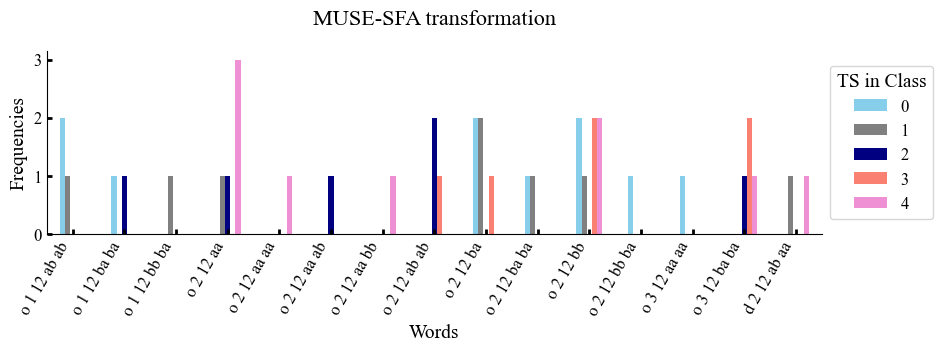

In [67]:
X_train, y_train = from_nested_to_3d_numpy(x_tr), y_tr
y_train = LabelEncoder().fit_transform(y_train)

# WEASEL+MUSE transformation
transformer = WEASELMUSE(word_size=2, n_bins=2, window_sizes=[12, 36],
                         chi2_threshold=15, sparse=False)
X_weasel = transformer.fit_transform(X_train, y_train)

# Visualize the transformation for the first time series
plt.figure(figsize=(8, 5))
vocabulary_length = len(transformer.vocabulary_)
freqs = np.concatenate([[X_weasel[y_train==0][0]], 
                        [X_weasel[y_train==1][0]], 
                        [X_weasel[y_train==2][0]],
                        [X_weasel[y_train==3][0]],
                        [X_weasel[y_train==4][0]]]).T
df_freqs = pd.DataFrame(freqs)

df_freqs.plot.bar(stacked=False, figsize=(10,3))
plt.xticks(np.arange(vocabulary_length),
           np.vectorize(transformer.vocabulary_.get)(
               np.arange(X_weasel[0].size)),
           fontsize=12, rotation=60, ha='right')
y_max = np.max(np.concatenate([X_weasel[y_train == 0][0],
                               X_weasel[y_train == 1][0],
                               X_weasel[y_train == 2][0],
                               X_weasel[y_train == 3][0],
                               X_weasel[y_train == 4][0]]))
plt.yticks(np.arange(y_max + 1), fontsize=12)
plt.xlabel("Words")
plt.ylabel("Frequencies")
plt.title("MUSE-SFA transformation", y=1.1)
plt.legend(title='TS in Class', loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=12)

plt.subplots_adjust(bottom=0.27)
plt.show()

#### SFA

- This differs a little bit from the above implementation which uses ´`pyts` library instead of `sktime`
- This is here for later investigations (not reported in the Article)

In [67]:
sfa = SFA(word_length=8, window_size=5, alphabet_size=8, anova=False, bigrams=False)
sfa_words = sfa.fit_transform(pd.DataFrame(x_tr.hr), y_tr)
#sfa_words[0][6]
#sfa.word_list(19700)

In [68]:
counter = 0
for i in sfa_words[0][6]:
    counter = counter+1 
print(counter)

32


### 7.4 Signal characteristics

In [68]:
reset_style()

In [69]:
# Let's get indexes for activities
run_index = META[META.label == 'Running'].index.tolist()
bik_index = META[META.label == 'Biking'].index.tolist()
ski_index = META[META.label == 'Skiing'].index.tolist()
rsk_index = META[META.label == 'R-Skiing'].index.tolist()
wal_index = META[META.label == 'Walking'].index.tolist()

# Data by category
CAT_DATA = [
    {
        'run': HR_DATA.iloc[run_index],
        'bik': HR_DATA.iloc[bik_index],
        'ski': HR_DATA.iloc[ski_index],
        'rsk': HR_DATA.iloc[rsk_index],
        'wal': HR_DATA.iloc[wal_index]
    },
    {
        'run': SPD_DATA.iloc[run_index],
        'bik': SPD_DATA.iloc[bik_index],
        'ski': SPD_DATA.iloc[ski_index],
        'rsk': SPD_DATA.iloc[rsk_index],
        'wal': SPD_DATA.iloc[wal_index]
    },
    {
        'run': ALT_DATA.iloc[run_index],
        'bik': ALT_DATA.iloc[bik_index],
        'ski': ALT_DATA.iloc[ski_index],
        'rsk': ALT_DATA.iloc[rsk_index],
        'wal': ALT_DATA.iloc[wal_index]
    }]

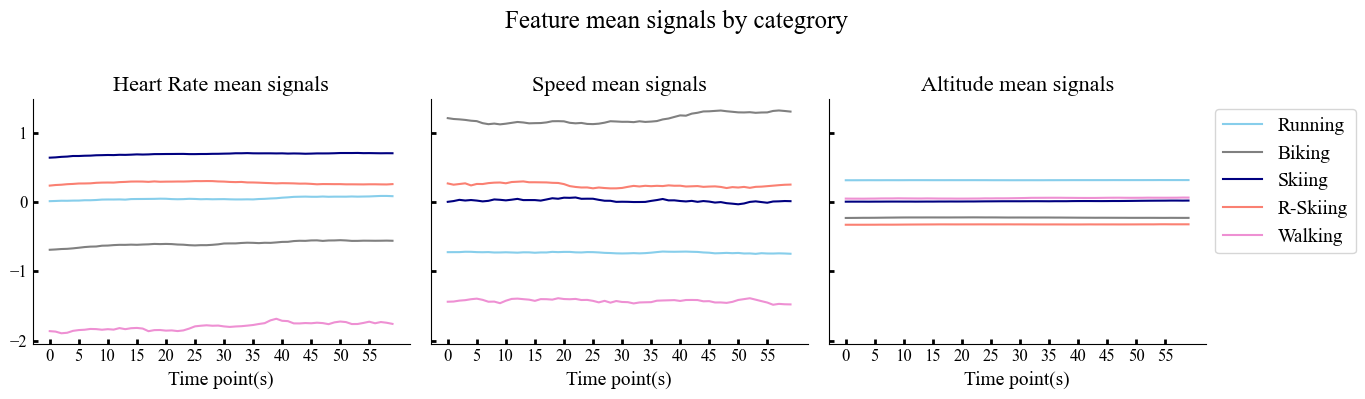

In [70]:
fig, axes = plt.subplots(1,3,figsize=(FIG_WIDTH,4), sharey=True)
fig.suptitle('Feature mean signals by categrory', y=1.0)

for i, data in enumerate(CAT_DATA):
    plot_cat_signals(axes[i], data, 'mean', FEAT_CODES.get(i)[0])

plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

#### Single category signals (heart rate for biking)

- Some biking activity signals with confidence interval by seaborn bootstrapping method
- You may test different features from `[hr=0, spd=1, alt=2]` or category from `['bik','run','ski','rsk','wal']`

In [71]:
reset_style()

In [72]:
@widgets.interact(cat=widgets.Dropdown(options=['Biking','Running','R-Skiing','Skiing','Walking']), 
                  feat=widgets.Dropdown(options=['Heart Rate','Speed','Altitude']), 
                  num=widgets.IntSlider(10, 1, 30, 1, layout=widgets.Layout(width='500px')))
def plot_category_with_ci(cat: str='Biking', feat: int=0, num: int=10):
    cat_code = get_cat(cat, abbr=False)
    feat_code = get_feat_codes([feat], abbr=False)[0]
    data = CAT_DATA[feat_code].get(cat_code).T
    data = pd.DataFrame(data.values.reshape(-1,1), columns=['Value(std)'])
    data['timepoint'] = np.tile(np.arange(0,SLEN), int(data.shape[0]/SLEN))
    
    fig, axs = plt.subplots(figsize=(FIG_WIDTH,4))
    sns.lineplot(CAT_DATA[feat_code].get(cat_code).T.iloc[:,:num], ax=axs, legend=False, palette=sns.color_palette(['grey'], num))
    sns.lineplot(data.iloc[:num*SLEN,:], x='timepoint', y='Value(std)', errorbar=('ci',95),  color=THEMA_COLOR, ax=axs, legend=False)
    plt.show()

interactive(children=(Dropdown(description='cat', options=('Biking', 'Running', 'R-Skiing', 'Skiing', 'Walking…

In [73]:
@widgets.interact(signal_index=widgets.IntSlider(10, 0, 30, 1, layout=widgets.Layout(width='500px')),
                  feat=widgets.IntSlider(0, 0, 2, 1, layout=widgets.Layout(width='500px')))
def signal_analysis(signal_index, feat):
    signal, label = get_signal3D(x_te, y_te, signal_index)
    plot_mean_analysis(CAT_DATA, feat, (signal, signal_index, label))

interactive(children=(IntSlider(value=10, description='signal_index', layout=Layout(width='500px'), max=30), I…

#### Seaborn extra

**Feature value divergency by categories**

In [74]:
reset_style()

In [75]:
feats = widgets.SelectMultiple(options=['Heart Rate', 'Speed', 'Altitude'],
                               value=['Heart Rate','Speed'],
                               rows=3,
                               description='Features',
                               disabled=False)
plot_type = widgets.Dropdown(options=['strip','violin','lm','pair'], 
                             description='Plot type')
button = widgets.Button(description='Run Interact')

def catval_distribution(feats, plot_type):
    feat_nums = get_feat_codes(feats, abbr=False)
    # Type as required by seaborn catplot() function (currently supports these type=['strip', 'violin'])
    plot_cat_analysis(data=CAT_DATA, feats=feat_nums, plot_type=plot_type)

button.on_click(catval_distribution, {'feats': feats, 'plot_type': plot_type})

out = widgets.interactive_output(catval_distribution, {'feats': feats, 'plot_type': plot_type})
ui = widgets.HBox([feats, plot_type, button], layout=widgets.Layout(display='flex', 
                                                                    flex_flow='row wrap', 
                                                                    justify_content='flex-start'))
display(ui, out)

Output()

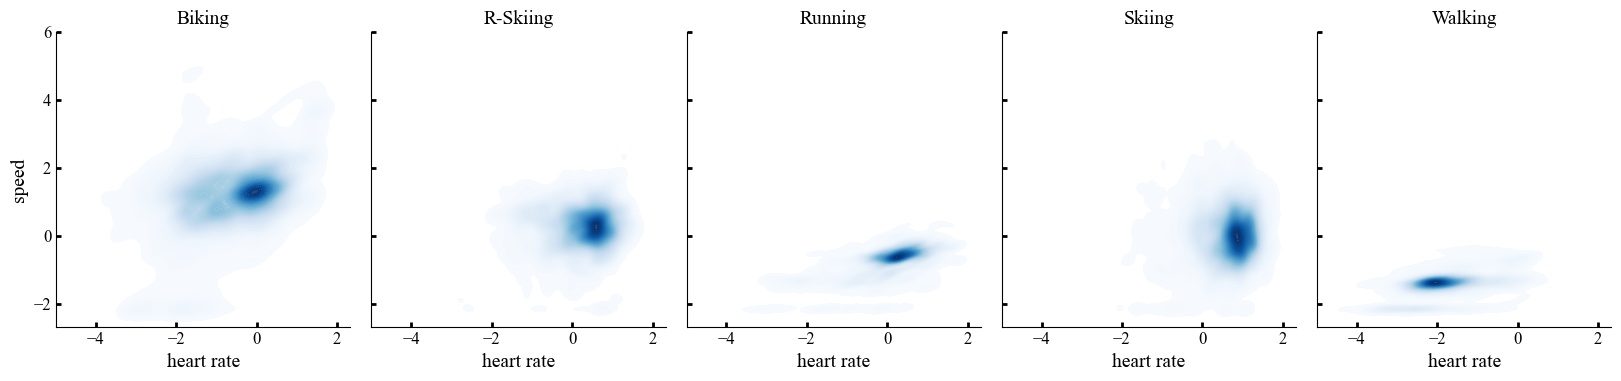

In [76]:
# lims=[(-5,3),(-3,6)] Consider these limits proper for the case data 
plot_cat_analysis_single(CAT_DATA, cats=get_categories()[:5], lims=[(-5,3),(-3,6)], 
                         cmap=sns.color_palette("Blues", as_cmap=True), fc='white', h=4)

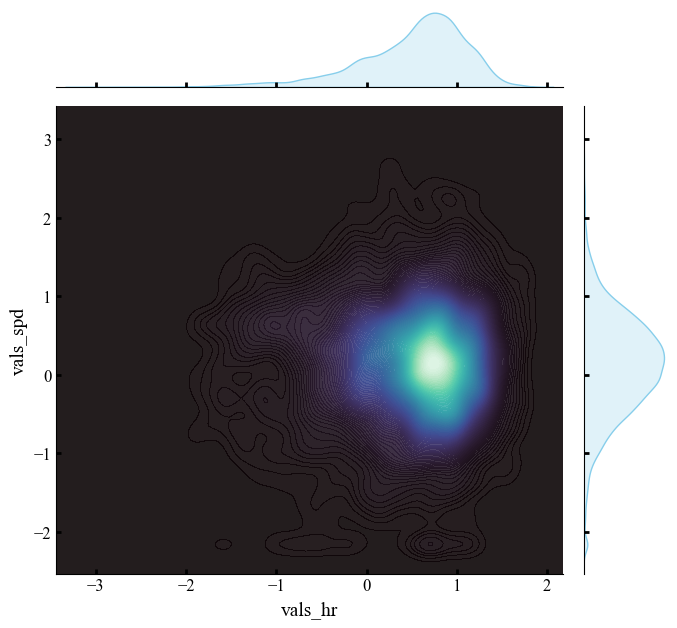

In [78]:
plot_cat_analysis_single(CAT_DATA, plot_type='kde-aio', cats=['Skiing','R-Skiing'], cmap='mako', fc=None, h=7)

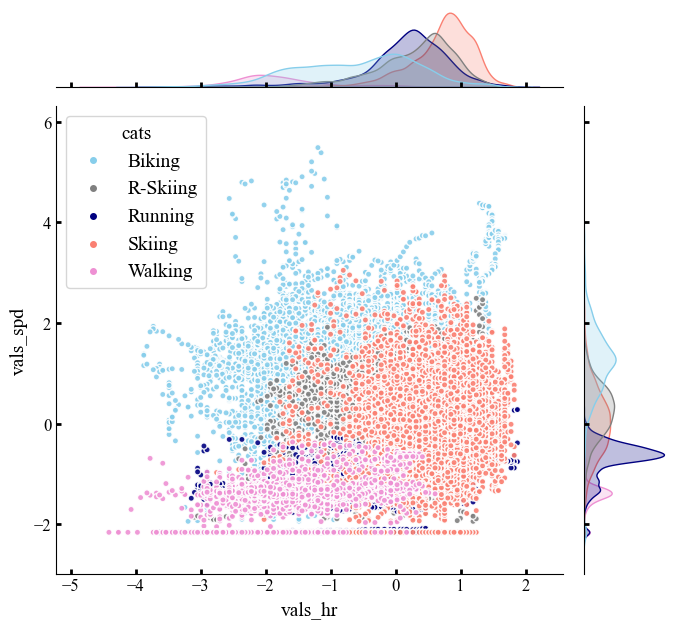

In [79]:
plot_cat_analysis_single(CAT_DATA, plot_type='scatter')

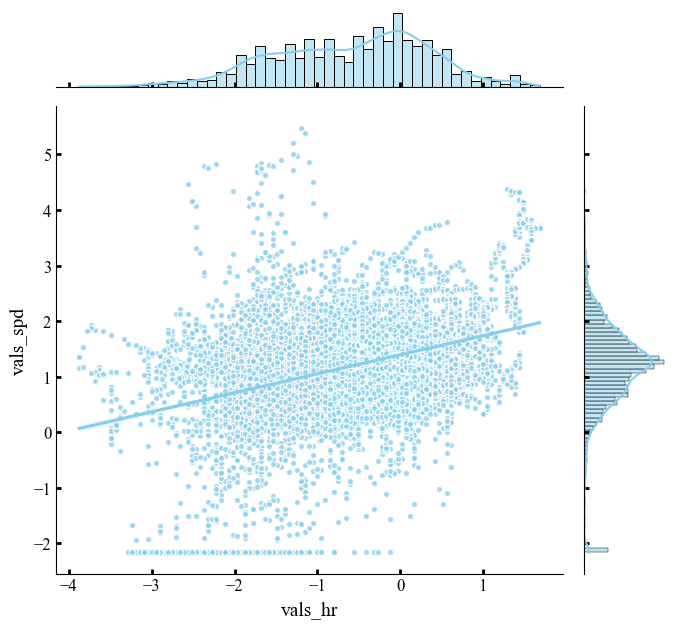

In [80]:
plot_cat_analysis_single(CAT_DATA, cmap='mako', cats=get_categories()[:1], plot_type='reg')

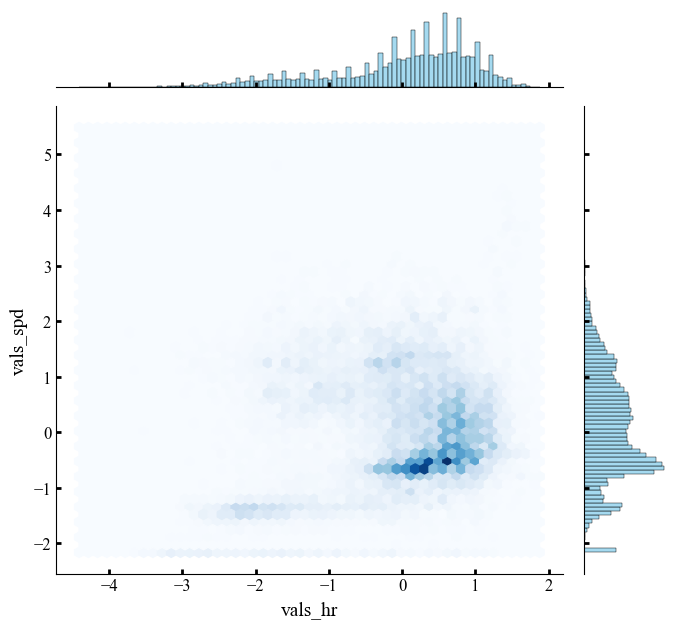

In [81]:
plot_cat_analysis_single(CAT_DATA, cmap=sns.color_palette("Blues", as_cmap=True), plot_type='hex')

Another version of KDE

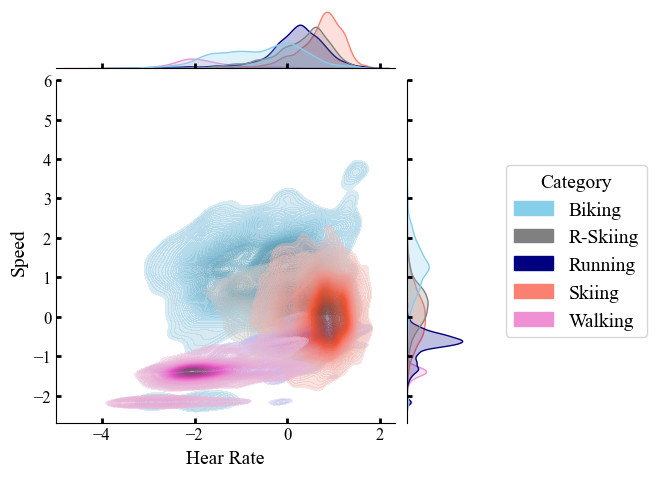

In [81]:
g = sns.jointplot(kind="kde", data=construct_plot_data(CAT_DATA), x="vals_hr", y="vals_spd", 
                  fill=True, thresh=0.05, height=5, hue="cats", levels=100, alpha=0.4, common_norm=False)

g.set_axis_labels(xlabel='Hear Rate', ylabel='Speed')
legend = g.ax_joint.get_legend()
labels = (x.get_text() for x in legend.get_texts())
g.ax_joint.legend(legend.legend_handles, labels, title='Category', bbox_to_anchor=(1.3,0.5), loc='center left')
plt.show()

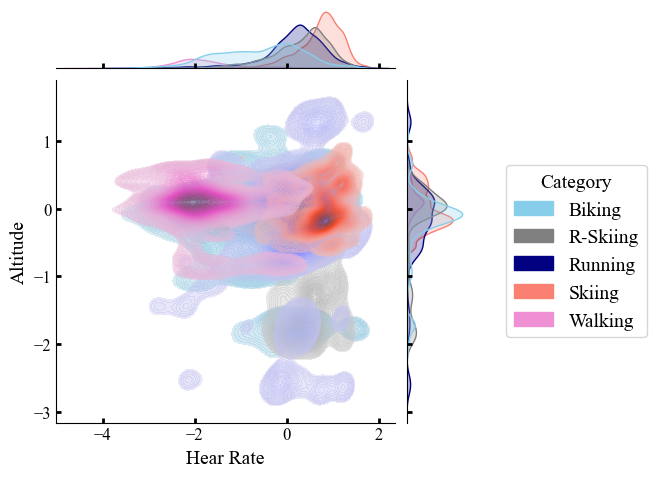

In [83]:
g = sns.jointplot(kind="kde", data=construct_plot_data(CAT_DATA), x="vals_hr", y="vals_alt", 
                  fill=True, thresh=0.05, height=5, hue="cats", levels=100, alpha=0.4, common_norm=False)

g.set_axis_labels(xlabel='Hear Rate', ylabel='Altitude')
legend = g.ax_joint.get_legend()
labels = (x.get_text() for x in legend.get_texts())
g.ax_joint.legend(legend.legend_handles, labels, title='Category', bbox_to_anchor=(1.3,0.5), loc='center left')
plt.show()

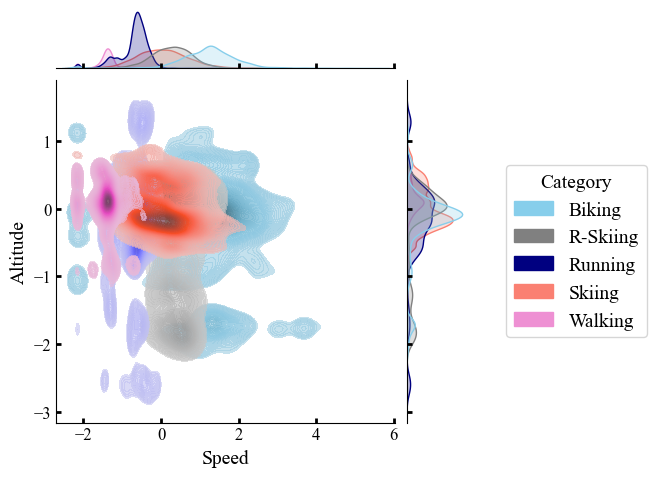

In [84]:
g = sns.jointplot(kind="kde", data=construct_plot_data(CAT_DATA), x="vals_spd", y="vals_alt", 
                  fill=True, thresh=0.05, height=5, hue="cats", levels=100, alpha=0.6, common_norm=False)

g.set_axis_labels(xlabel='Speed', ylabel='Altitude')
legend = g.ax_joint.get_legend()
labels = (x.get_text() for x in legend.get_texts())
g.ax_joint.legend(legend.legend_handles, labels, title='Category', bbox_to_anchor=(1.3,0.5), loc='center left')
plt.show()

#### Differential value plots

The following regression plot shows that there is decreasing trend between Speed and Altitude derivatives among all the activity data, which means, that when athlete goes to uphill speed decreases (speed derivative is negative). However, the trend is quite moderate because speed can decrease for several other kind of reasons which makes interpretations difficult. 

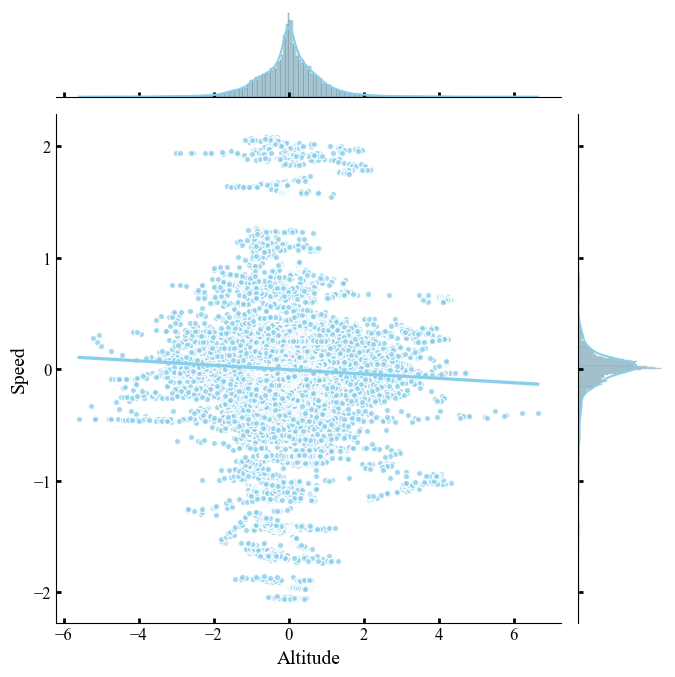

In [85]:
g = sns.jointplot(kind="reg", data=construct_plot_data(CAT_DATA, diff_feats=[1,2]), x="vals_spd", y="vals_alt", height=7,
                  scatter_kws={"s":20,'edgecolors':'white','linewidth':1})
g.set_axis_labels(xlabel='Altitude', ylabel='Speed')
plt.show()

The following scatter plot with regression line shows positive correlation between altitude and heart rate differential features. Positive correlation is expected, but as for speed, heart rate can increase for many other kind of reasons which makes interpretations difficult. Therefore, analysis should consider only those segments when absolute altitude derivative has greater value than some certain appropriate threshold value (in order to reject steady altitude segments)  

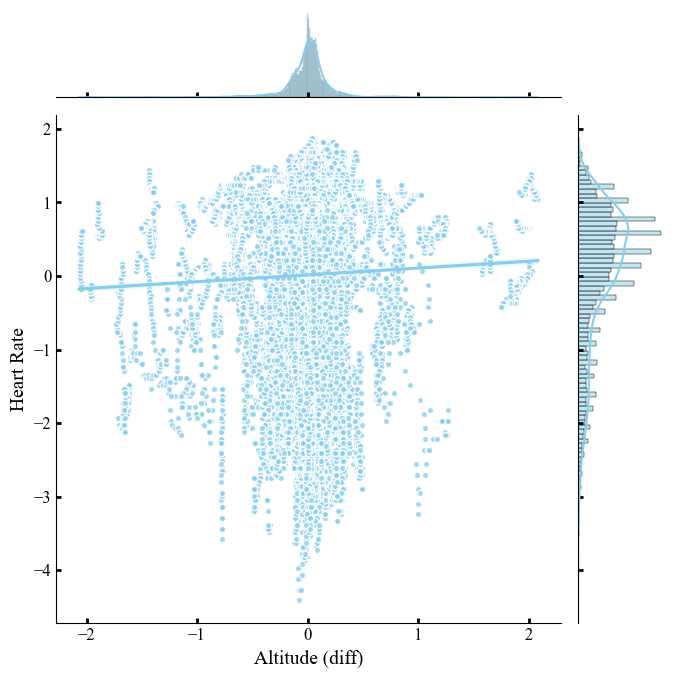

In [86]:
g = sns.jointplot(kind="reg", data=construct_plot_data(CAT_DATA, diff_feats=[1,2]), x="vals_alt", y="vals_hr", height=7,
                  scatter_kws={"s":20,'edgecolors':'white','linewidth':1})
g.set_axis_labels(xlabel='Altitude (diff)', ylabel='Heart Rate')
plt.show()

### 7.3 Misclassification Analysis

In [87]:
# Getting indexes of misclassified signals (for the shake of test)
preds_muse[preds_muse.MUSE != preds_muse.Valid].index.tolist()[:5]

[20, 36, 48, 52, 68]

**We need to reset index in order to pick right misclassified signals from test data** 

- For some reason pandas iloc[] selector does not care about indexes, so resetting might not be necessary

In [88]:
x_te_copy = x_te.copy()
x_te_copy['target'] = y_te
x_te_copy = x_te_copy.reset_index()

**Sample of misclassified signals**

In [89]:
# Indexes of misclassified segments
idxs_fail = preds_muse[preds_muse.MUSE != preds_muse.Valid].index.tolist()
# Indexes of well classified segments
idxs_valid = preds_muse[preds_muse.MUSE == preds_muse.Valid].index.tolist()

In [126]:
@widgets.interact(start_index=widgets.IntSlider(0, 0, len(idxs_fail)-6, 1, layout=widgets.Layout(width='500px')))
def plot_misclass_sample(start_index):
    range = (start_index, start_index+6)
    plot_signal_sample(x_te_copy, idxs_fail[range[0]:range[1]], cmap[3], 'Misclassified signals')

interactive(children=(IntSlider(value=0, description='start_index', layout=Layout(width='500px'), max=10), Out…

In [91]:
@widgets.interact(start_index=widgets.IntSlider(0, 0, len(idxs_valid)-6, 1, layout=widgets.Layout(width='500px')))
def plot_misclass_sample(start_index):
    range = (start_index, start_index+6)
    plot_signal_sample(x_te_copy, idxs_valid[range[0]:range[1]], cmap[2], 'Correctly classified signals')

interactive(children=(IntSlider(value=0, description='start_index', layout=Layout(width='500px'), max=206), Ou…

#### Misclassified signal analysis

1. Select failure signal index from the dropdown menu (18 misclassified cases)
2. Signal data with correct and predicted labels will be printed out
3. Execute the following cells and section 7.4 for analysis

Generate signal with metadata from the given index

In [92]:
@widgets.interact(fail_index=widgets.Dropdown(options=idxs_fail))
def signal(fail_index):
    global ACT, SIG_IDX, SIG_CAT
    SIG_IDX = fail_index
    SIGNAL, SIG_CAT = get_signal3D(x_te_copy, y_te, SIG_IDX)
    ACT = (SIGNAL, SIG_IDX, SIG_CAT)
    print('Actual: %s, Prediction: %s' % (SIG_CAT, preds_muse.MUSE[SIG_IDX]))
    print(ACT)

interactive(children=(Dropdown(description='fail_index', options=(20, 36, 48, 52, 68, 72, 96, 109, 112, 142, 1…

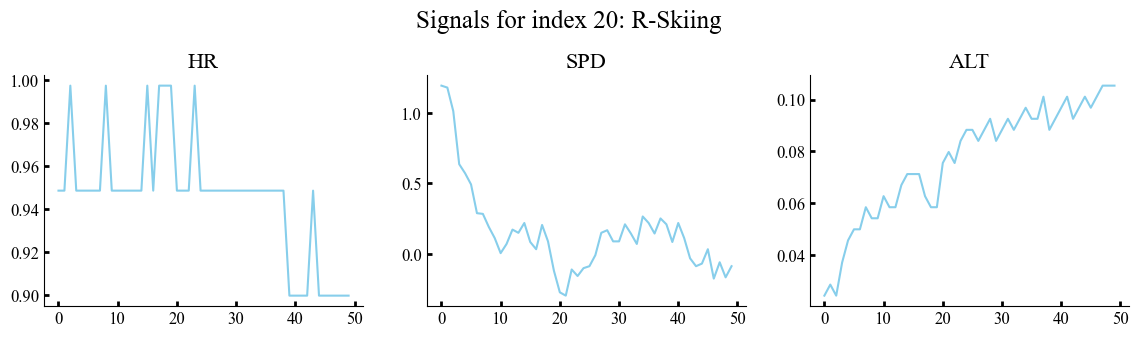

In [93]:
fig, ax = plt.subplots(1,3,figsize=(14,3))
plt.suptitle('Signals for index ' + str(SIG_IDX) + ': ' + SIG_CAT, y=1.1)

ax[0].plot(ACT[0].hr, label='HR')
ax[1].plot(ACT[0].spd, label='SPD')
ax[2].plot(ACT[0].alt, label='ALT')

ax[0].set_title('HR'), ax[1].set_title('SPD'), ax[2].set_title('ALT') 

plt.show()

**Plotting investigated misclassified signal with mean signals by categories in order to reflect signal characteristics**

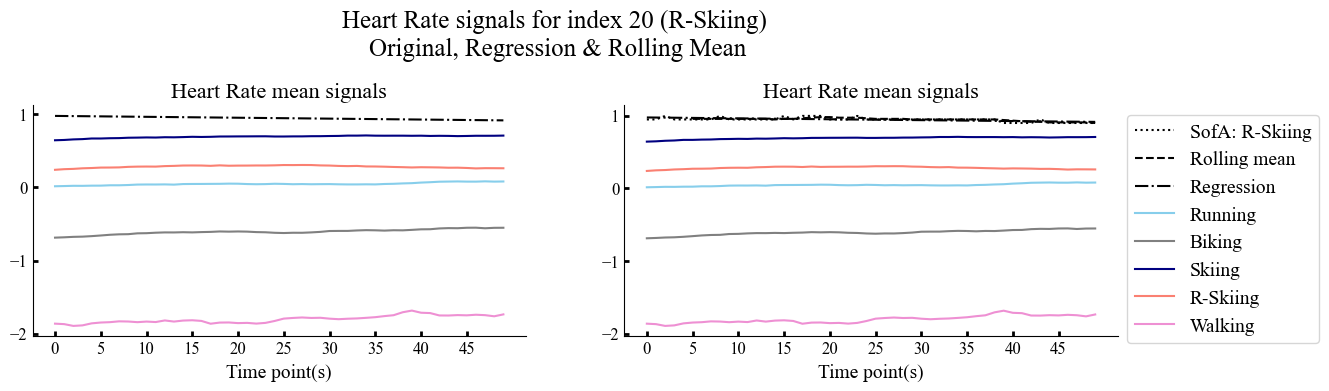

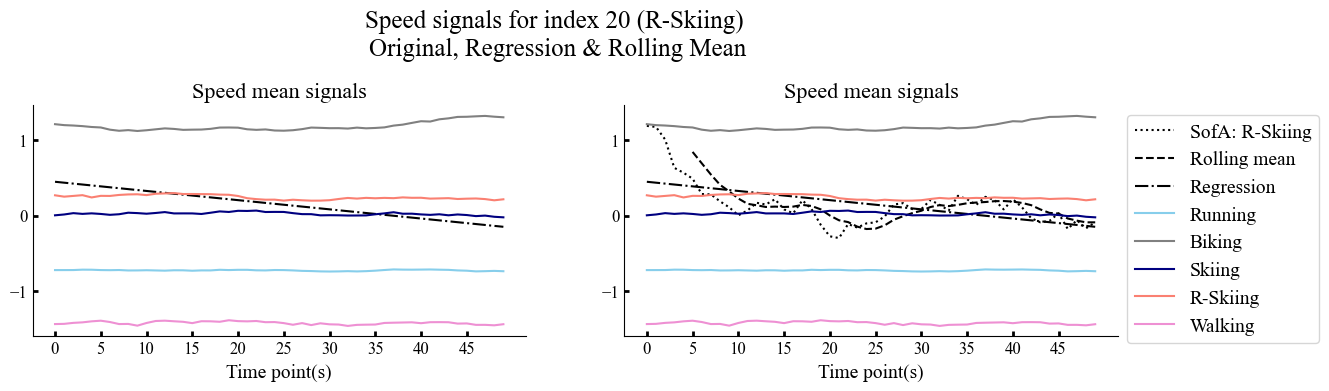

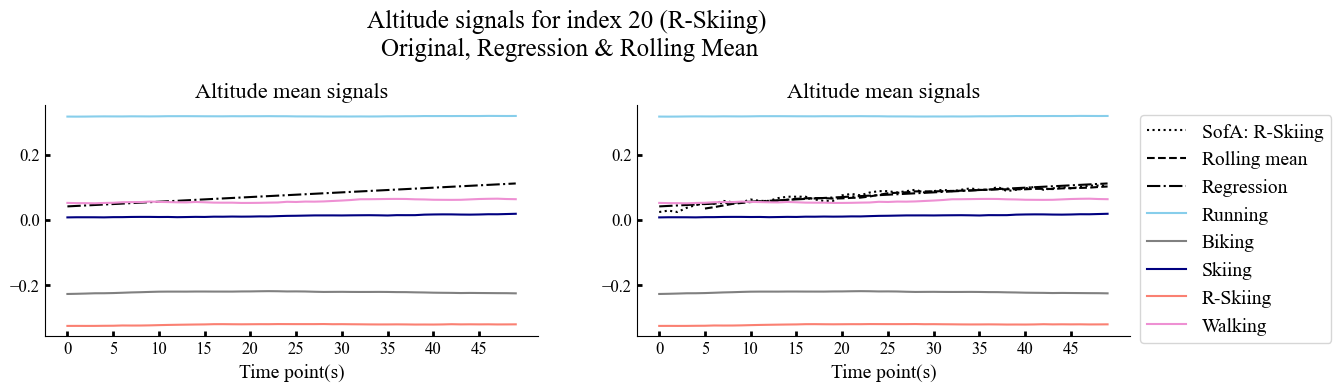

In [94]:
plot_analysis(CAT_DATA, 0, ACT)
plot_analysis(CAT_DATA, 1, ACT)
plot_analysis(CAT_DATA, 2, ACT)

**Plots with confidence intervals**

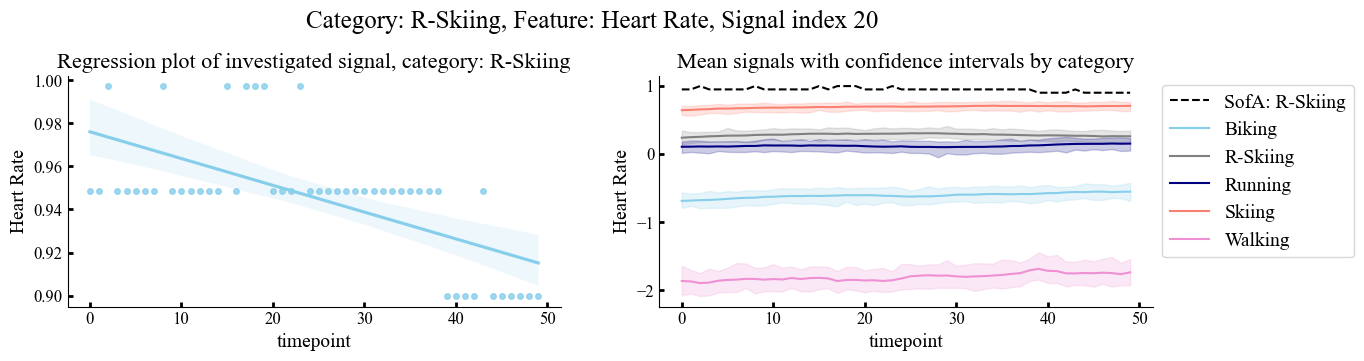

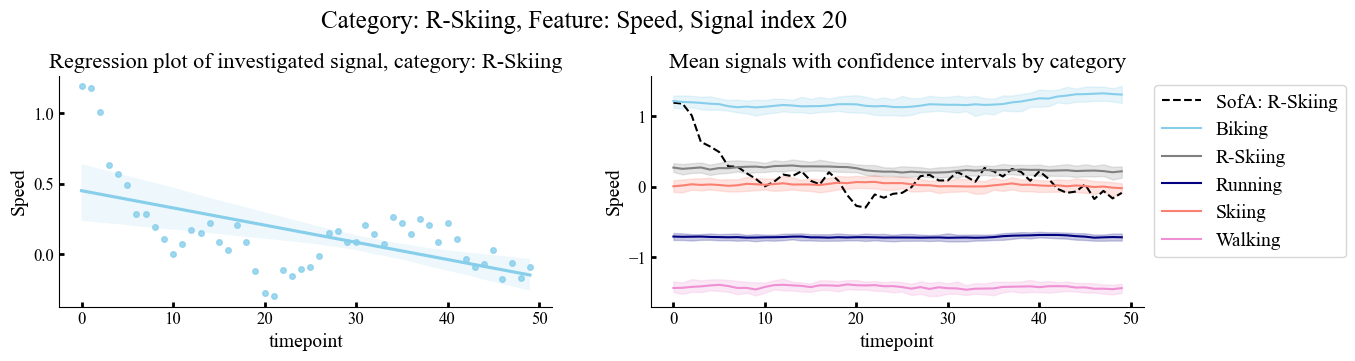

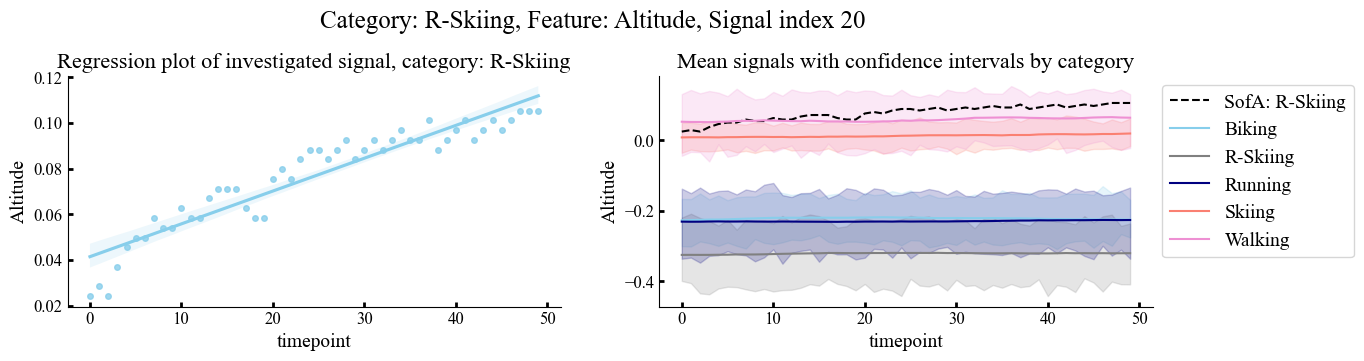

In [95]:
plot_mean_analysis(CAT_DATA, 0, ACT)
plot_mean_analysis(CAT_DATA, 1, ACT)
plot_mean_analysis(CAT_DATA, 2, ACT)

**Conclusions** (Case index 21: Running predicted as Skiing activity)

In this analysis attribute signals (hr, speed, altitude) from running activity was investigated using *mean signals* by categories. We used MUSE-misclassified running activity signal that was predicted as skiing. However, in this mean signal analysis with confidence intervals we found that investigated signal from index wasn't actually problematic, but quite close to its right category.

**Conclusions** (Case index 15: Biking predicted as R-Skiing activity)



**Slope, Derivative Slope, and Wavelet signal transformation analysis**

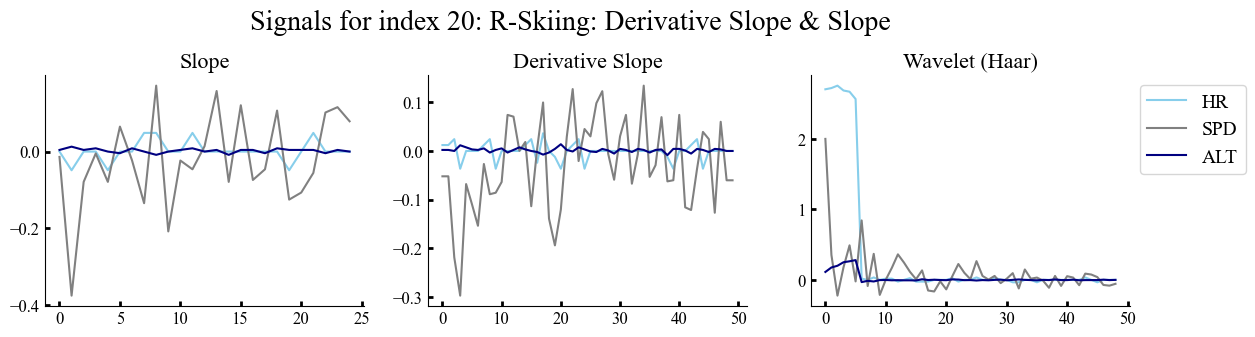

In [96]:
# Data transformations
slope = SlopeTransformer(num_intervals=int(SLEN/2)).fit_transform(ACT[0])
der_slope = DerivativeSlopeTransformer().fit_transform(ACT[0])
dwt = DWTTransformer().fit_transform(ACT[0])

fig, ax = plt.subplots(1,3,figsize=(FIG_WIDTH,3))
plt.suptitle('Signals for index ' + str(ACT[1]) + ': ' + ACT[2] + ': Derivative Slope & Slope', y=1.1, fontsize=20)

# Signals
ax[0].plot(slope)
ax[1].plot(der_slope)
ax[2].plot(dwt, label=['HR','SPD','ALT'])
# Titles
ax[0].set_title('Slope'); 
ax[1].set_title('Derivative Slope'); 
ax[2].set_title('Wavelet (Haar)');

plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

### 7.4 Single signal analysis

* This is a continuation of misclassification analysis (same signal)
* One may analyze also other than misclassified signals: initialize `ACT` variable using function `get_signal3D(x, y, idx)`.

In [97]:
reset_style()

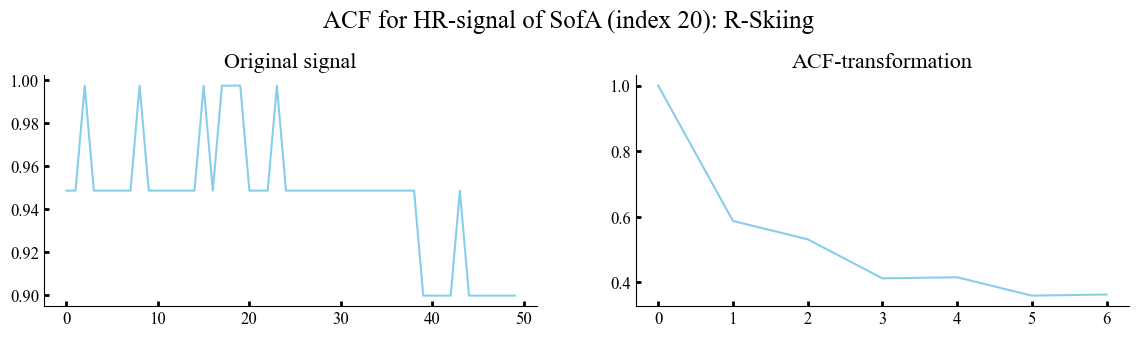

In [98]:
y = ACT[0].hr.values
idx = pd.PeriodIndex(pd.date_range("2020-01-01", periods=SLEN, freq="s"))
y = pd.DataFrame(index=idx, data=y, columns=['hr'])

transformer = AutoCorrelationTransformer(n_lags=6)
y_hat = transformer.fit_transform(y)

fig, ax = plt.subplots(1,2,figsize=(FIG_WIDTH,3))
ax[0].plot(ACT[0].hr)
ax[1].plot(y_hat)
ax[0].set_title('Original signal')
ax[1].set_title('ACF-transformation')
plt.suptitle(f'ACF for HR-signal of SofA (index %d): %s' % (SIG_IDX, SIG_CAT), y=1.1)
plt.show()

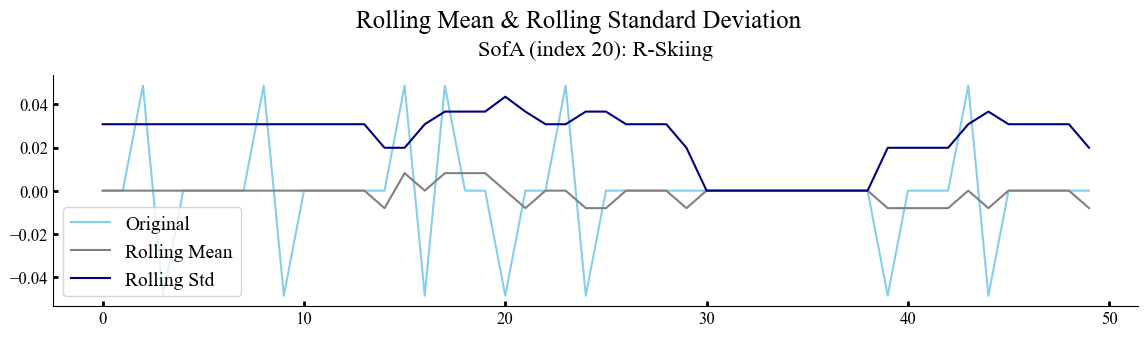

In [99]:
y_diff = y.diff(1)
y_diff.fillna(method='bfill', inplace=True)

rolling_mean = y_diff.rolling(window=6).mean()
rolling_std  = y_diff.rolling(window=6).std()

rolling_mean.fillna(method='bfill', inplace=True)
rolling_std.fillna(method='bfill', inplace=True)

plt.figure(figsize=(FIG_WIDTH,3))

plt.plot(y_diff.values, label='Original')
plt.plot(rolling_mean.values, label='Rolling Mean')
plt.plot(rolling_std.values, label='Rolling Std')

plt.legend(loc = 'best')
plt.suptitle(f'Rolling Mean & Rolling Standard Deviation', y=1.1)
plt.title('SofA (index %d): %s' % (SIG_IDX, SIG_CAT), y=1.05)
plt.show()

In [100]:
result = adfuller(y_diff)

print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -11.327826273996335
p-value: 1.1319687986053354e-20
Critical Values:
	1%: -3.5714715250448363
	5%: -2.922629480573571
	10%: -2.5993358475635153


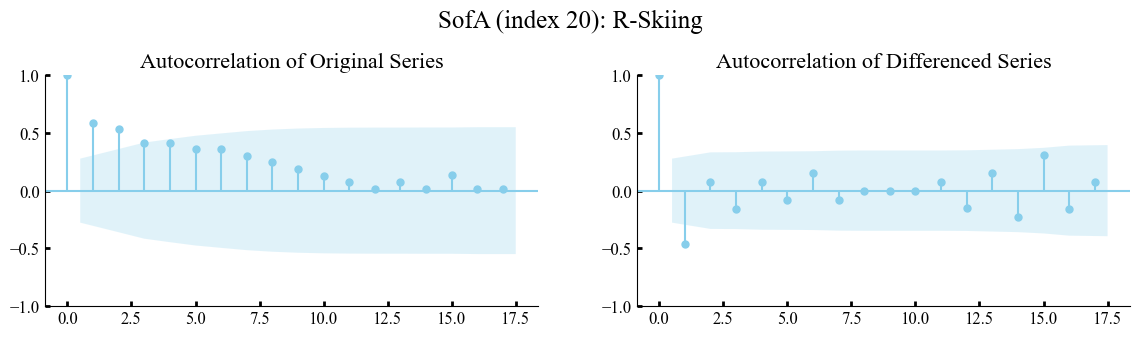

In [101]:
# Original Series
fig, ax = plt.subplots(1,2,figsize=(FIG_WIDTH,3))

plot_acf(y[:], title='Autocorrelation of Original Series', ax=ax[0])

# Usual Differencing
plot_acf(y_diff[:], title='Autocorrelation of Differenced Series', ax=ax[1])
plt.suptitle('SofA (index %d): %s' % (SIG_IDX, SIG_CAT), y=1.1)
plt.show();

In [102]:
# 1,1,2 ARIMA Model
model = ARIMA(y.values, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   50
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 119.550
Date:                Fri, 07 Jul 2023   AIC                           -231.100
Time:                        20:12:33   BIC                           -223.533
Sample:                             0   HQIC                          -228.229
                                 - 50                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4871      7.423     -0.066      0.948     -15.036      14.062
ma.L1         -0.1889      7.488     -0.025      0.980     -14.865      14.487
ma.L2         -0.3089      4.989     -0.062      0.9

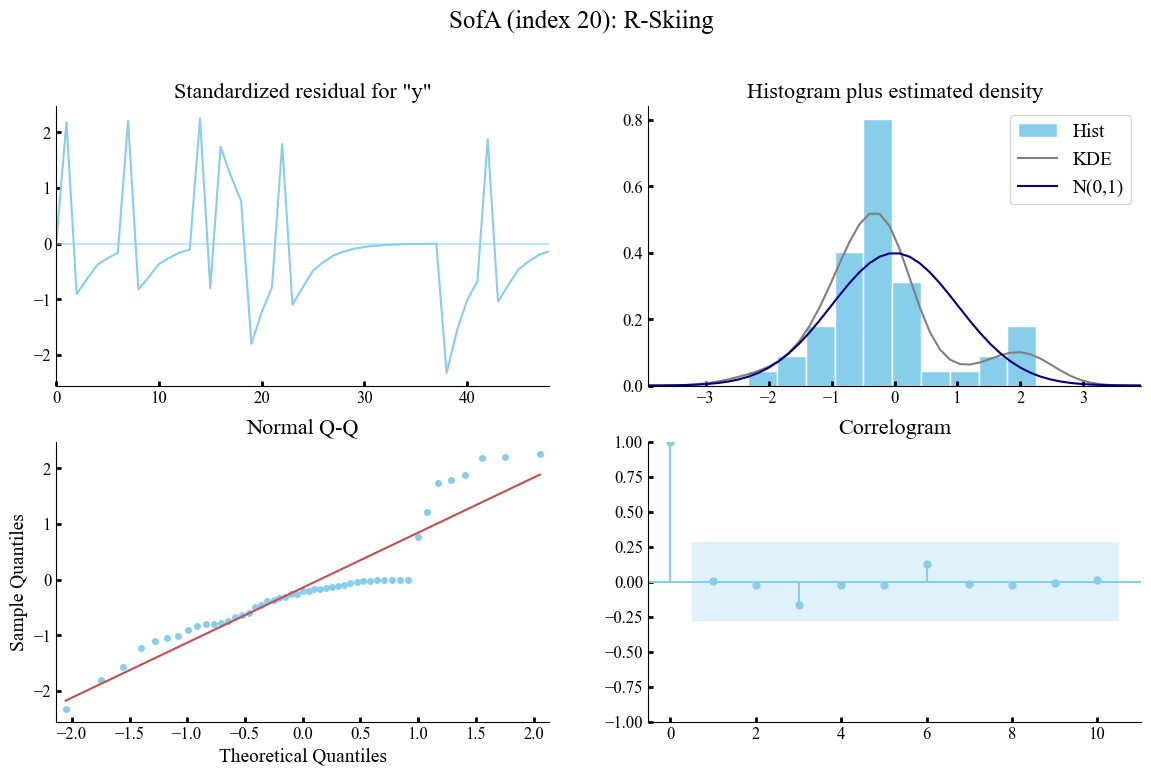

In [103]:
model_fit.plot_diagnostics(figsize=(FIG_WIDTH,8));
plt.suptitle('SofA (index %d): %s' % (SIG_IDX, SIG_CAT), y=1.0)
plt.show()

## 8 - Basic motions dataset

http://www.timeseriesclassification.com/description.php?Dataset=BasicMotions

The data was generated as part of a student project where four students performed four activities whilst wearing a smart watch. The watch collects 3D accelerometer and a 3D gyroscope. The data order is accelerometer x, y, z then gyroscope x, y, z. There are classes: walking, resting, running and badminton. Participants were required to record motion a total of five times, and the data is sampled once every tenth of a second, for a ten second period.

| Train Size | Test Size | Length | Number of Classes | Number of Dimensions | Type |
| --- | --- | --- | --- | --- | --- |
| 40 | 40 | 100 | 4 | 6 | HAR |

In [104]:
from sktime.datasets import load_basic_motions

In [105]:
def plot_confmatrix_4(ax, yval, ypred):
    cm = pd.DataFrame(confusion_matrix(yval, ypred))
    cm_norm = cm.apply(lambda x: x/x.sum(), axis = 1)
    sns.set(font_scale=1.1) # for label size
    sns.heatmap(cm_norm, annot=True, xticklabels=('Pred A1', 'Pred A2','Pred A3','Pred A4'), 
                                     yticklabels=('Act A1', 'Act A2','Act A3','Act A4'),
                                     fmt='.1%',
                                     cmap='Blues',
                                     ax=ax,
                                     annot_kws={"size": 16}) # font size

In [106]:
X_train, y_train = load_basic_motions(split="train")
X_test, y_test = load_basic_motions(split="test")
X_train.head(5)

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5
0,0 0.079106 1 0.079106 2 -0.903497 3...,0 0.394032 1 0.394032 2 -3.666397 3...,0 0.551444 1 0.551444 2 -0.282844 3...,0 0.351565 1 0.351565 2 -0.095881 3...,0 0.023970 1 0.023970 2 -0.319605 3...,0 0.633883 1 0.633883 2 0.972131 3...
1,0 0.377751 1 0.377751 2 2.952965 3...,0 -0.610850 1 -0.610850 2 0.970717 3...,0 -0.147376 1 -0.147376 2 -5.962515 3...,0 -0.103872 1 -0.103872 2 -7.593275 3...,0 -0.109198 1 -0.109198 2 -0.697804 3...,0 -0.037287 1 -0.037287 2 -2.865789 3...
2,0 -0.813905 1 -0.813905 2 -0.424628 3...,0 0.825666 1 0.825666 2 -1.305033 3...,0 0.032712 1 0.032712 2 0.826170 3...,0 0.021307 1 0.021307 2 -0.372872 3...,0 0.122515 1 0.122515 2 -0.045277 3...,0 0.775041 1 0.775041 2 0.383526 3...
3,0 0.289855 1 0.289855 2 -0.669185 3...,0 0.284130 1 0.284130 2 -0.210466 3...,0 0.213680 1 0.213680 2 0.252267 3...,0 -0.314278 1 -0.314278 2 0.018644 3...,0 0.074574 1 0.074574 2 0.007990 3...,0 -0.079901 1 -0.079901 2 0.237040 3...
4,0 -0.123238 1 -0.123238 2 -0.249547 3...,0 0.379341 1 0.379341 2 0.541501 3...,0 -0.286006 1 -0.286006 2 0.208420 3...,0 -0.098545 1 -0.098545 2 -0.023970 3...,0 0.058594 1 0.058594 2 0.175783 3...,0 -0.074574 1 -0.074574 2 0.114525 3...


In [107]:
(X_train.shape[0], X_train.shape[1], len(X_train.iloc[0,0]))

(40, 6, 100)

In [108]:
muse.fit(X_train, y_train)

y_pred = muse.predict(X_test)
print('model', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

model 1.0
              precision    recall  f1-score   support

   badminton      1.000     1.000     1.000        10
     running      1.000     1.000     1.000        10
    standing      1.000     1.000     1.000        10
     walking      1.000     1.000     1.000        10

    accuracy                          1.000        40
   macro avg      1.000     1.000     1.000        40
weighted avg      1.000     1.000     1.000        40



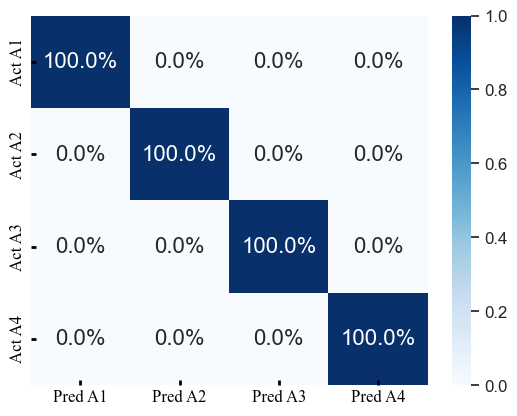

In [109]:
fig = plt.figure()
spec = gridspec.GridSpec(ncols=1, nrows=1, width_ratios=[1], wspace=0.3)
ax = fig.add_subplot(spec[0])
plot_confmatrix_4(ax, y_test, y_pred)

## 9 - Test Section

### 9.1 Data Transformers

In [110]:
from sktime.transformations.panel.segment import RandomIntervalSegmenter
from sktime.transformations.panel.shapelet_transform import ShapeletTransform
from sktime.transformations.series.augmenter import RandomSamplesAugmenter
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.detrend import Detrender, Deseasonalizer

### 9.2 Teaser

In [111]:
muse = MUSE(window_inc=5,
            alphabet_size=8,
            support_probabilities=True,
            use_first_order_differences=False,
            variance=False,
            bigrams=False,
            anova=False,
            feature_selection='chi2',
            p_threshold=0.05,
            random_state=0,
            n_jobs=1)

In [112]:
teaser = TEASER(
    random_state=0,
    classification_points=[10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60],
    estimator=muse,
)
teaser.fit(x_tr, y_tr)

TEASER(classification_points=[10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60],
       estimator=MUSE(alphabet_size=8, anova=False, bigrams=False,
                      random_state=0, support_probabilities=True,
                      use_first_order_differences=False, window_inc=5),
       random_state=0)

In [113]:
y_pred, decisions = teaser.predict(x_te) 

In [114]:
print('model', accuracy_score(y_te, y_pred))
print(classification_report(y_te, y_pred, digits=3))

model 0.8596491228070176
              precision    recall  f1-score   support

          -1      0.000     0.000     0.000         0
      Biking      0.857     0.980     0.914        49
    R-Skiing      0.857     0.682     0.759        44
     Running      0.923     0.973     0.947        74
      Skiing      0.792     0.857     0.824        49
     Walking      0.800     0.333     0.471        12

    accuracy                          0.860       228
   macro avg      0.705     0.637     0.653       228
weighted avg      0.862     0.860     0.852       228



c:\Users\jarno\anaconda3\envs\mts\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jarno\anaconda3\envs\mts\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jarno\anaconda3\envs\mts\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Determine the accuracy and earliness on train data

In [115]:
print("Earliness on Train Data %2.2f" % teaser._train_earliness)
print("Accuracy on Train Data %2.2f" % teaser._train_accuracy)
teaser._compute_harmonic_mean

Earliness on Train Data 0.34
Accuracy on Train Data 0.88


<bound method TEASER._compute_harmonic_mean of TEASER(classification_points=[10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60],
       estimator=MUSE(alphabet_size=8, anova=False, bigrams=False,
                      random_state=0, support_probabilities=True,
                      use_first_order_differences=False, window_inc=5),
       random_state=0)>

#### Determine the accuracy and earliness on test data

In [116]:
hm, acc, earl = teaser.score(x_te.reset_index(drop=True), y_te.reset_index(drop=True))
print("Earliness on Test Data %2.2f" % earl)
print("Accuracy on Test Data %2.2f" % acc)
print("Harmonic Mean on Test Data %2.2f" % hm)

Earliness on Test Data 0.39
Accuracy on Test Data 0.86
Harmonic Mean on Test Data 0.72


### 9.3 Feature Extraction by tsfresh

In [117]:
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

In [118]:
t = TSFreshFeatureExtractor(default_fc_parameters="efficient", show_warnings=False)
Xt = t.fit_transform(x_tr)
Xt.head()

Feature Extraction: 100%|██████████| 2736/2736 [02:38<00:00, 17.26it/s]


,alt__variance_larger_than_standard_deviation,alt__has_duplicate_max,alt__has_duplicate_min,alt__has_duplicate,alt__sum_values,alt__abs_energy,alt__mean_abs_change,alt__mean_change,alt__mean_second_derivative_central,alt__median,...,spd__fourier_entropy__bins_5,spd__fourier_entropy__bins_10,spd__fourier_entropy__bins_100,spd__permutation_entropy__dimension_3__tau_1,spd__permutation_entropy__dimension_4__tau_1,spd__permutation_entropy__dimension_5__tau_1,spd__permutation_entropy__dimension_6__tau_1,spd__permutation_entropy__dimension_7__tau_1,spd__query_similarity_count__query_None__threshold_0.0,spd__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,1.0,-1.168392,0.051752,0.002877,-0.001656,0.000089,-0.029177,...,0.484390,0.484390,0.484390,0.573165,0.737904,0.903601,1.069060,1.232148,0.0,0.642751
1,0.0,1.0,1.0,1.0,12.919024,3.344690,0.002877,-0.000610,0.000044,0.259149,...,0.589280,0.642599,1.612796,1.681136,2.746585,3.444249,3.702615,3.784190,0.0,2.139436
2,0.0,1.0,1.0,1.0,8.698782,1.515435,0.001569,0.000349,0.000000,0.173719,...,0.535961,0.589280,0.799059,1.053993,1.612592,2.056335,2.434868,2.734964,0.0,1.390231
3,0.0,0.0,1.0,1.0,12.790879,3.811231,0.009066,-0.006276,0.000222,0.197213,...,0.431071,0.431071,0.642599,1.629662,2.493494,3.018346,3.421280,3.614764,0.0,2.713531
4,0.0,1.0,1.0,1.0,3.201357,0.262026,0.002441,0.002092,0.000000,0.081882,...,0.484390,0.893115,1.903563,1.710099,2.821127,3.451636,3.806662,3.784190,0.0,1.418215


In [119]:
Xt.shape

(912, 2331)

### 9.4 MUSE hyperparameter tuning

In [120]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [121]:
muse_t = MUSE()

muse_params = {'alphabet_size':[7,8,9],
               'window_inc':[3,4,5],
              'anova':[False],
              'variance':[False],
              'bigrams':[False],
              'feature_selection':['chi2'],
              'p_threshold':[0.04,0.05,0.06],
              'use_first_order_differences':[False],
              'support_probabilities':[True],
              'random_state':[0]
              }

gscv = GridSearchCV(estimator=muse_t,
                          refit=True,
                          verbose=2,
                          param_grid=muse_params,
                          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0))

In [122]:
gscv.fit(x_tr, y_tr)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END alphabet_size=7, anova=False, bigrams=False, feature_selection=chi2, p_threshold=0.04, random_state=0, support_probabilities=True, use_first_order_differences=False, variance=False, window_inc=3; total time=   7.4s
[CV] END alphabet_size=7, anova=False, bigrams=False, feature_selection=chi2, p_threshold=0.04, random_state=0, support_probabilities=True, use_first_order_differences=False, variance=False, window_inc=3; total time=   7.2s
[CV] END alphabet_size=7, anova=False, bigrams=False, feature_selection=chi2, p_threshold=0.04, random_state=0, support_probabilities=True, use_first_order_differences=False, variance=False, window_inc=3; total time=   7.4s
[CV] END alphabet_size=7, anova=False, bigrams=False, feature_selection=chi2, p_threshold=0.04, random_state=0, support_probabilities=True, use_first_order_differences=False, variance=False, window_inc=3; total time=   7.4s
[CV] END alphabet_size=7, anova=False, big

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=MUSE(),
             param_grid={'alphabet_size': [7, 8, 9], 'anova': [False],
                         'bigrams': [False], 'feature_selection': ['chi2'],
                         'p_threshold': [0.04, 0.05, 0.06], 'random_state': [0],
                         'support_probabilities': [True],
                         'use_first_order_differences': [False],
                         'variance': [False], 'window_inc': [3, 4, 5]},
             verbose=2)

In [123]:
muse_best = gscv.best_estimator_
muse_best.get_params()

{'alphabet_size': 8,
 'anova': False,
 'bigrams': False,
 'feature_selection': 'chi2',
 'n_jobs': 1,
 'p_threshold': 0.06,
 'random_state': 0,
 'support_probabilities': True,
 'use_first_order_differences': False,
 'variance': False,
 'window_inc': 3}

MUSE 0.9298245614035088


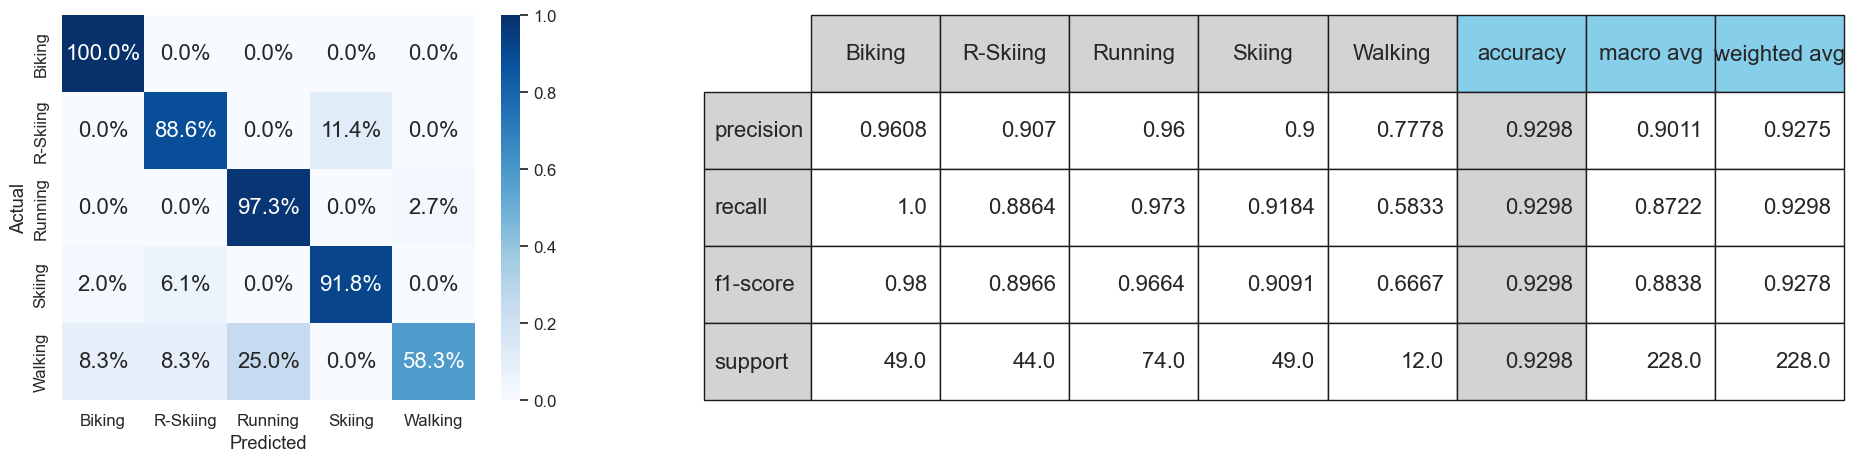

In [124]:
muse_clf = {'MUSE': muse_best}
classify_report(muse_clf, x_tr, y_tr, x_te, y_te)